## Problem Statement:
Develop a predictive model to identify and classify potential loan defaulters based on historical customer data and relevant features.\
When the company receives a loan application, the company has to decide for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company\

If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.\

The data given below contains the information about the loan application at the time of applying for the loan. It contains two types of scenarios:\

The client with payment difficulties: he/she had late payment more than X days on at least one of the first Y instalments of the loan in our sample,\

All other cases: All other cases when the payment is paid on time.\

## Imports

In [39]:
import numpy as np
import pandas as pd 
from numpy import percentile
import matplotlib.pyplot as plt
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import OneClassSVM
from skopt import BayesSearchCV
import imblearn
print(imblearn.__version__)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , accuracy_score ,f1_score ,precision_score,recall_score
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', 500)

0.11.0


## Read dataset

In [40]:
data=pd.read_csv("application_data.csv") 

## Data Information

In [41]:
data.shape

(307511, 122)

In [42]:
data.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [43]:
data.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

In [44]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [46]:
data=data.drop(['SK_ID_CURR'],axis=1)

## Handling missing values and Splitting the data

In [47]:
data.isnull().sum()

TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE                     0
FLAG_PHONE               

In [48]:
column_name ='CODE_GENDER','ORGANIZATION_TYPE'
for s in column_name:
    data[s] = data[s].replace('XNA', np.nan)


In [49]:
x=data.loc[:, data.columns != 'TARGET']
y=data.loc[:,['TARGET']]

In [50]:
#x_train , x_test, y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=0)
# Create instance of StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and test sets
for train_index, test_index in split.split(x, y):
    x_train = x.loc[train_index]
    x_test = x.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]

In [51]:
x_train.shape

(246008, 120)

In [52]:
x_test.shape

(61503, 120)

In [53]:
categorical_columns = x_train.select_dtypes(include=['object']).columns
numerical_columns = x_train.select_dtypes(include=['int64', 'float64']).columns
numerical_data = x_train.select_dtypes(include=['int64', 'float64'])


In [54]:
imputer_cat = SimpleImputer(strategy='most_frequent')
x_train[categorical_columns] = imputer_cat.fit_transform(x_train[categorical_columns])
x_test[categorical_columns] = imputer_cat.transform(x_test[categorical_columns])

In [55]:
imputer_num = SimpleImputer(strategy='median')
x_train[numerical_columns] = imputer_num.fit_transform(x_train[numerical_columns])
x_test[numerical_columns] = imputer_num.transform(x_test[numerical_columns])

In [56]:
x_train.isnull().sum()

NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBERS                 0
REGION_RATING_CLIENT            0
REGION_RATING_

In [17]:
x_test.isnull().sum()

SK_ID_CURR                      0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBERS                 0
REGION_RATING_

## Data Visualization

Numerical analysis

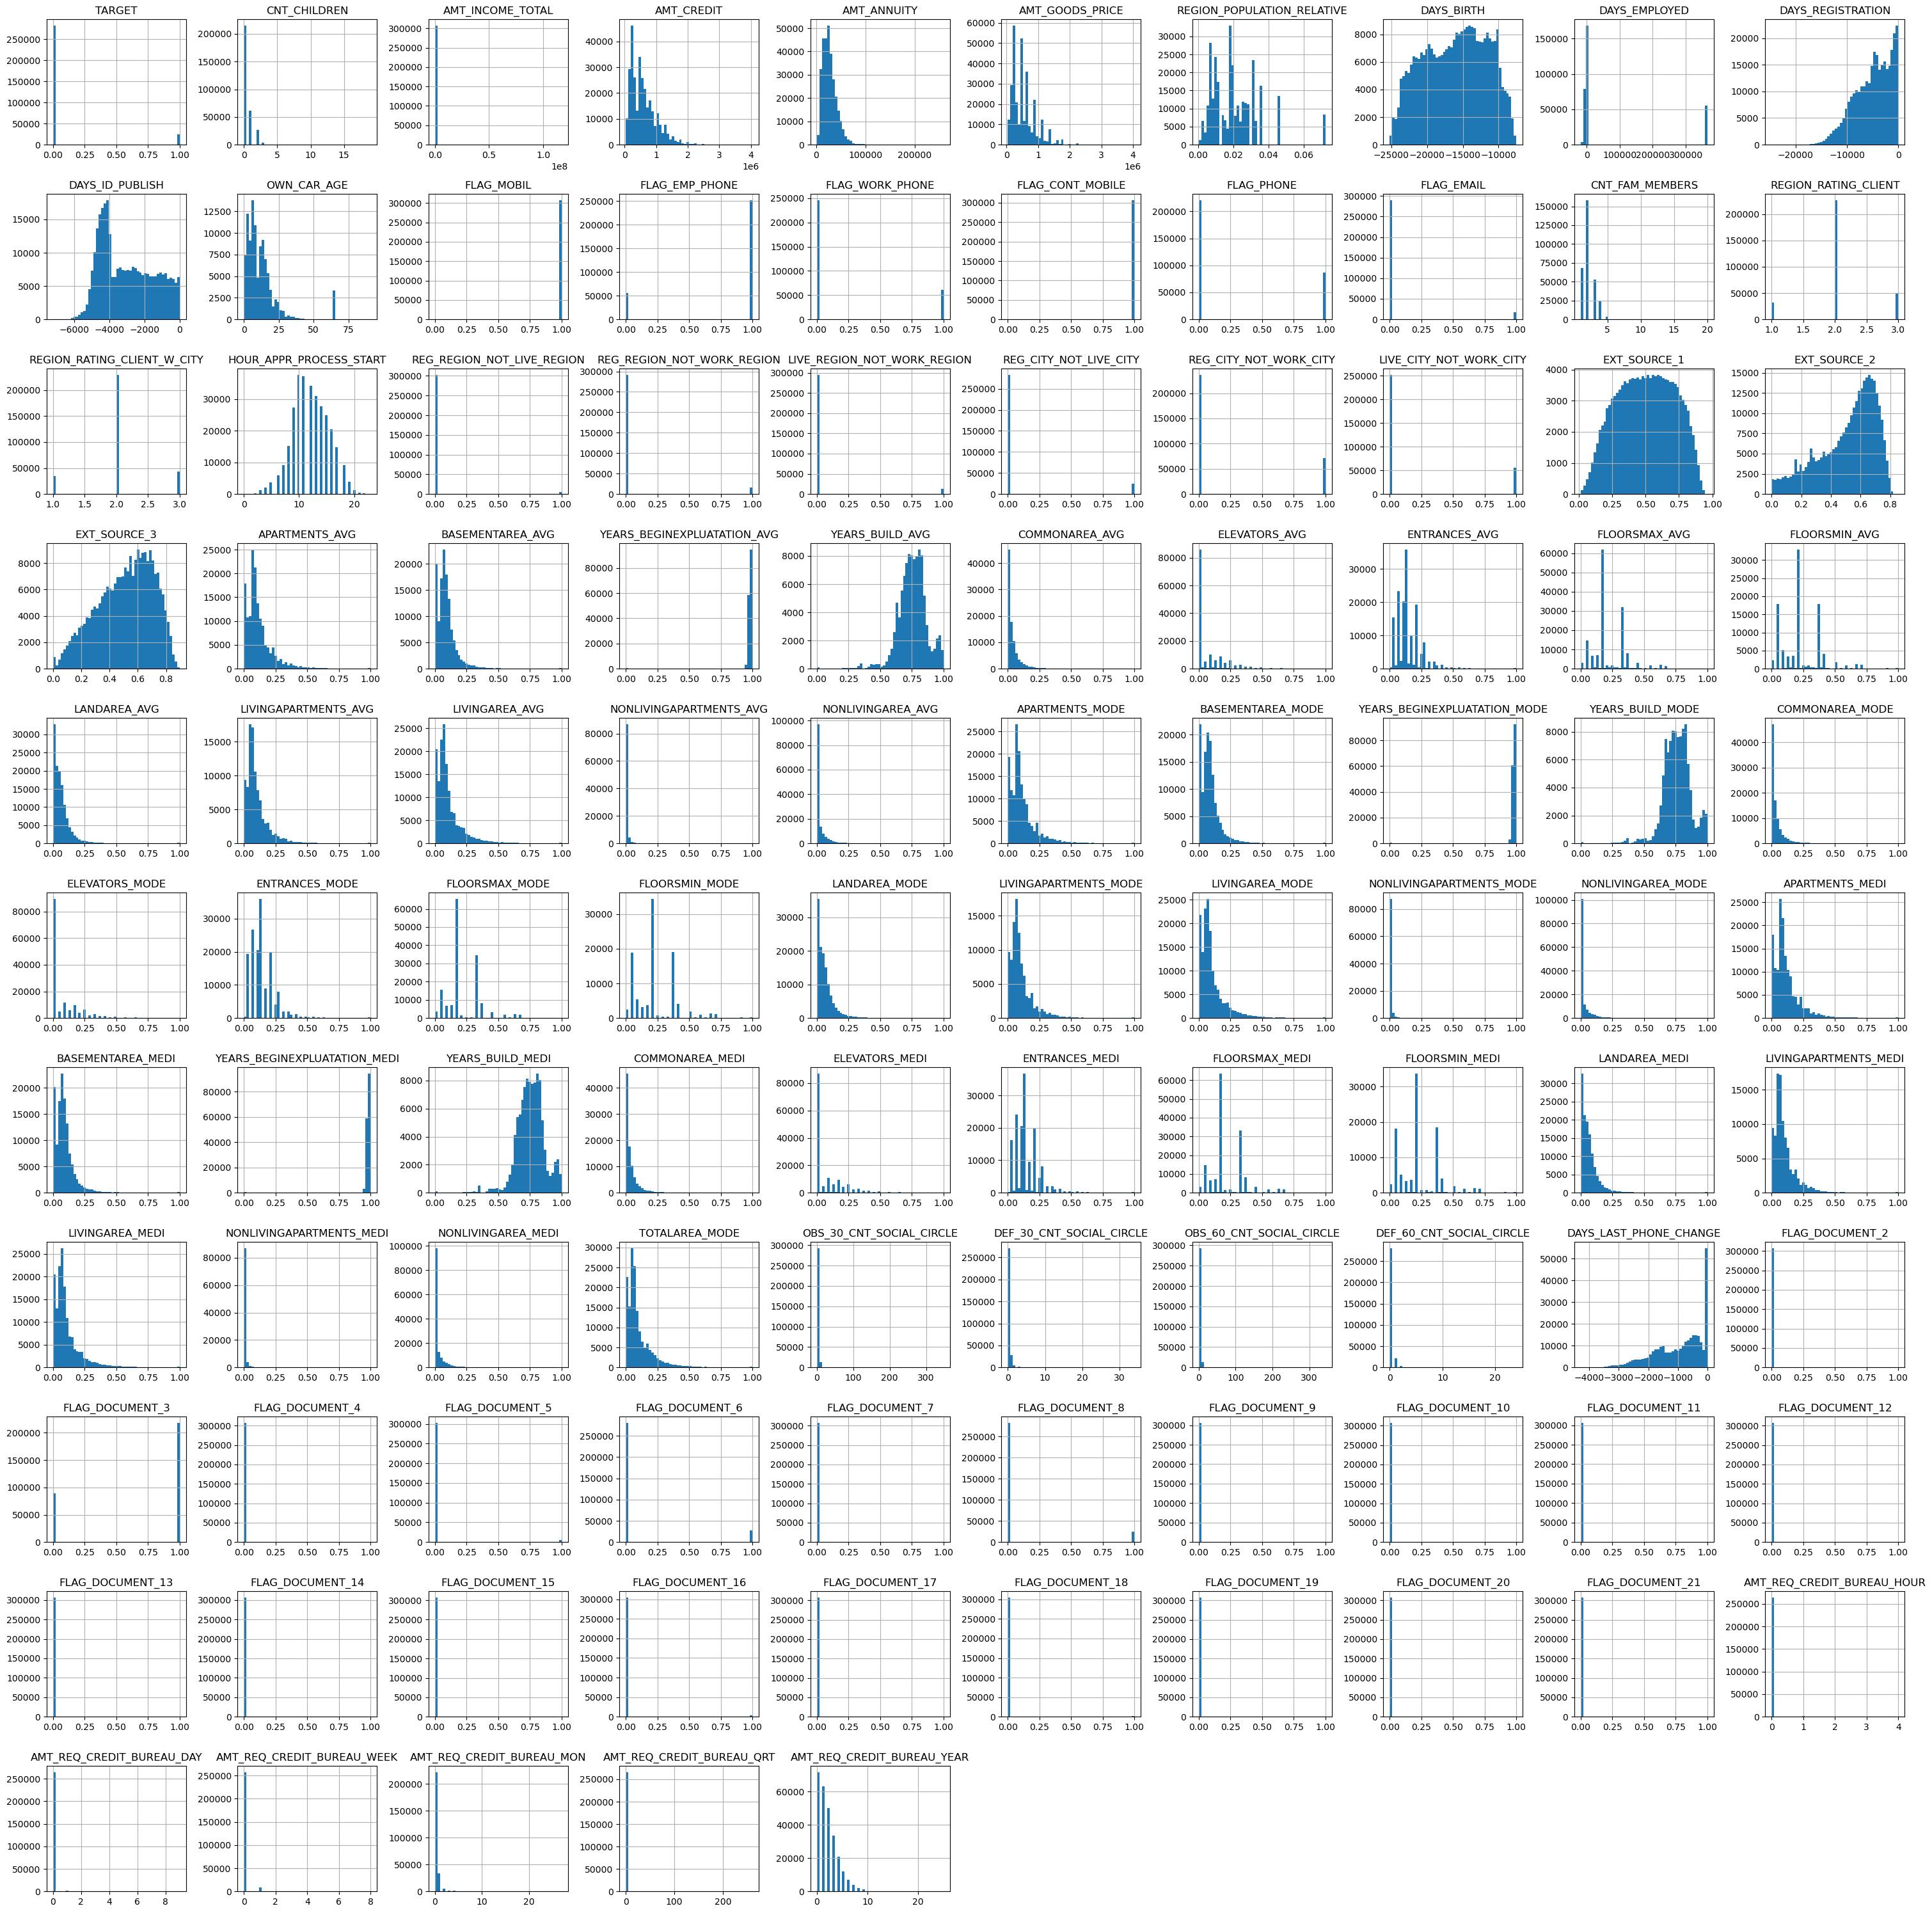

In [57]:
data.hist(figsize=(30, 30), bins=50)
plt.tight_layout()


Categorical analysis

In [58]:
print(data.nunique())


TARGET                               2
NAME_CONTRACT_TYPE                   2
CODE_GENDER                          2
FLAG_OWN_CAR                         2
FLAG_OWN_REALTY                      2
CNT_CHILDREN                        15
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13672
AMT_GOODS_PRICE                   1002
NAME_TYPE_SUITE                      7
NAME_INCOME_TYPE                     8
NAME_EDUCATION_TYPE                  5
NAME_FAMILY_STATUS                   6
NAME_HOUSING_TYPE                    6
REGION_POPULATION_RELATIVE          81
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12574
DAYS_REGISTRATION                15688
DAYS_ID_PUBLISH                   6168
OWN_CAR_AGE                         62
FLAG_MOBIL                           2
FLAG_EMP_PHONE                       2
FLAG_WORK_PHONE                      2
FLAG_CONT_MOBILE                     2
FLAG_PHONE               

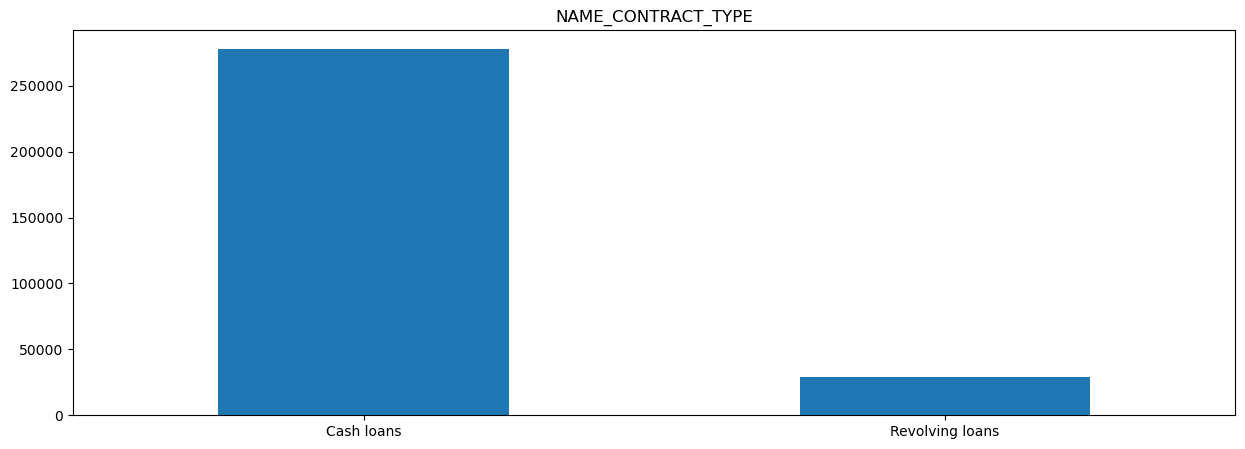

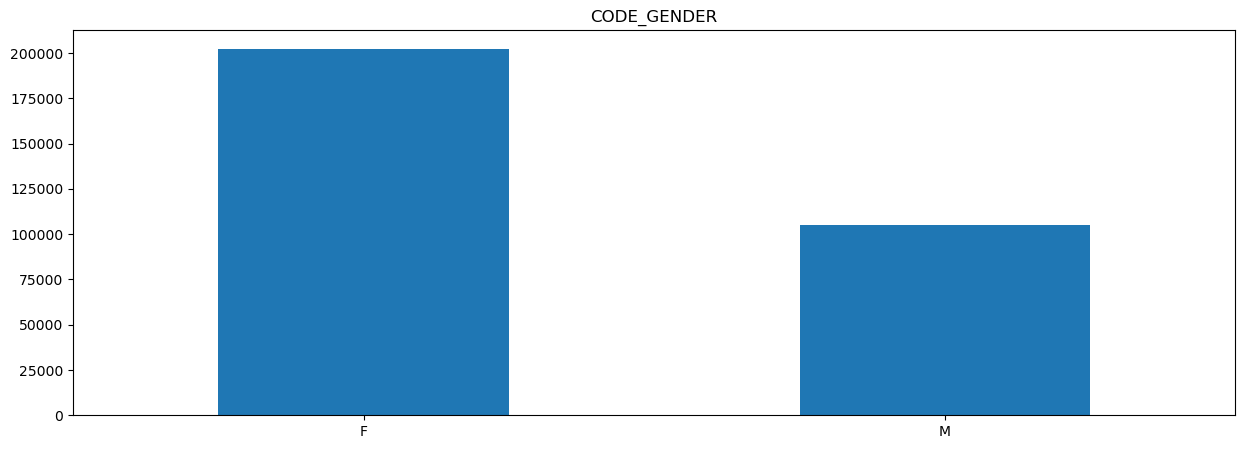

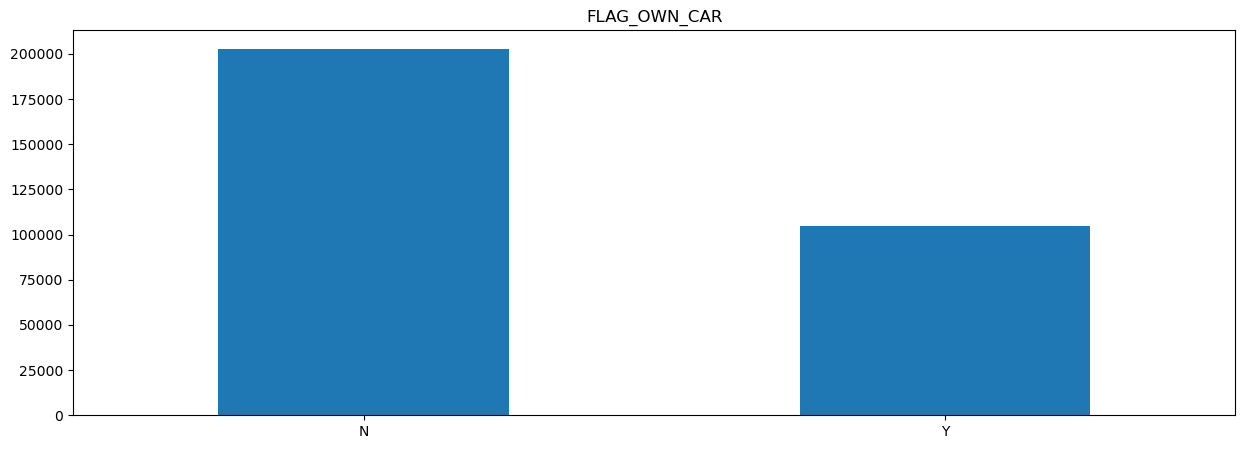

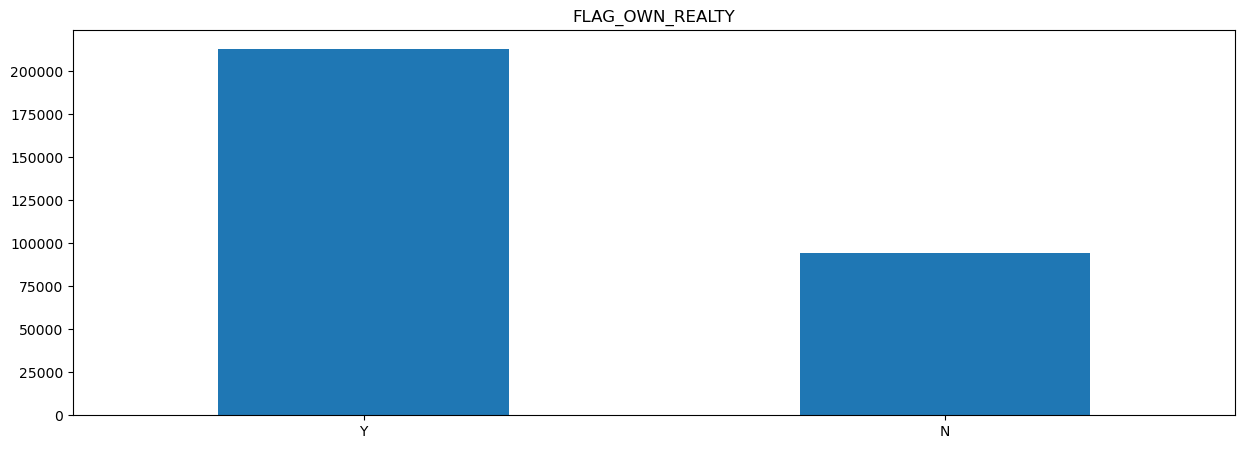

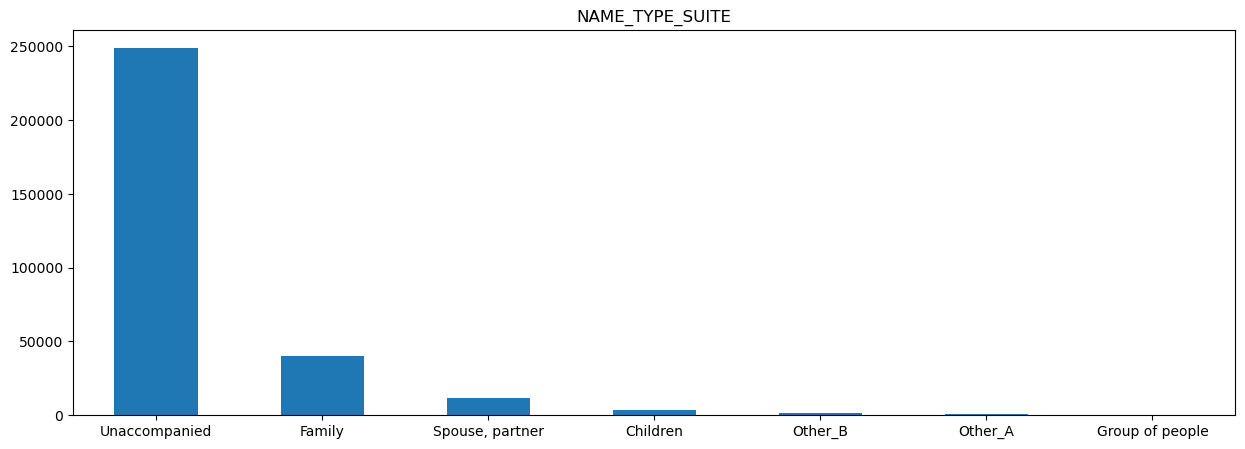

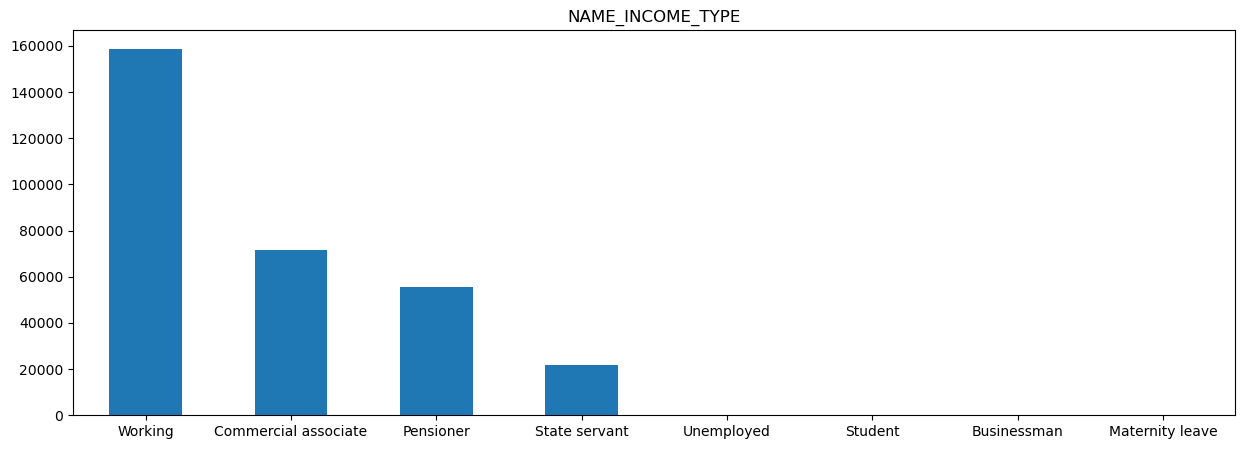

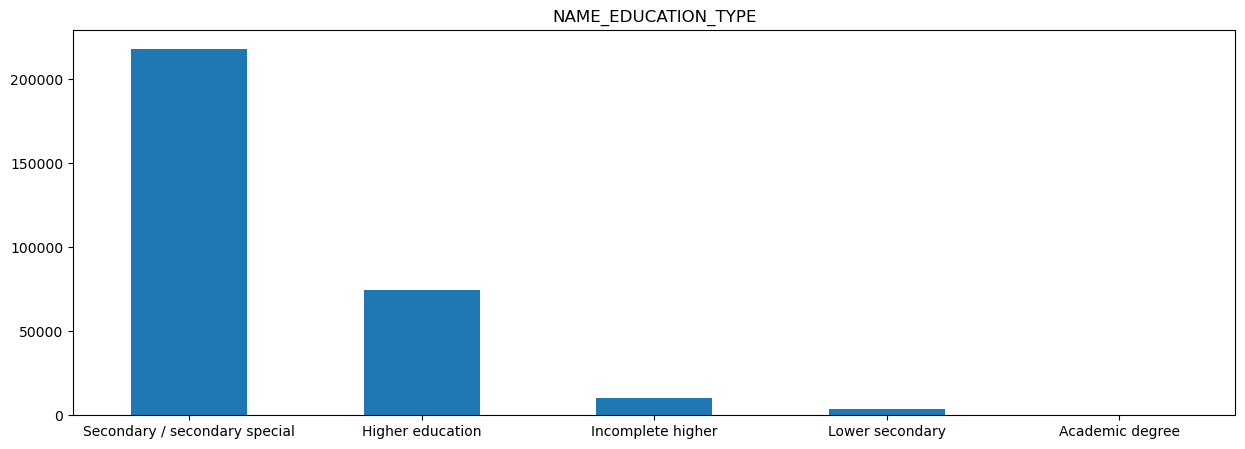

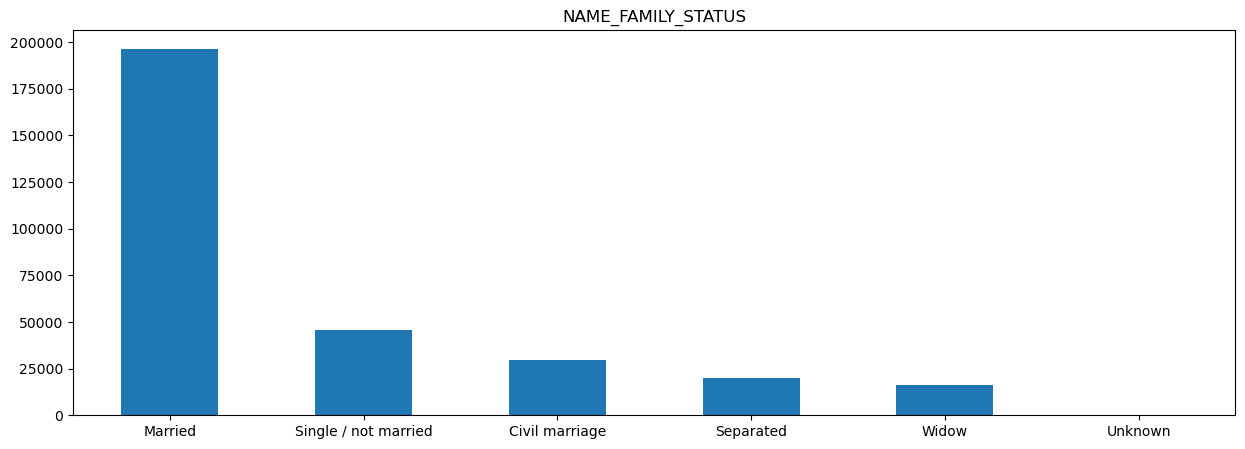

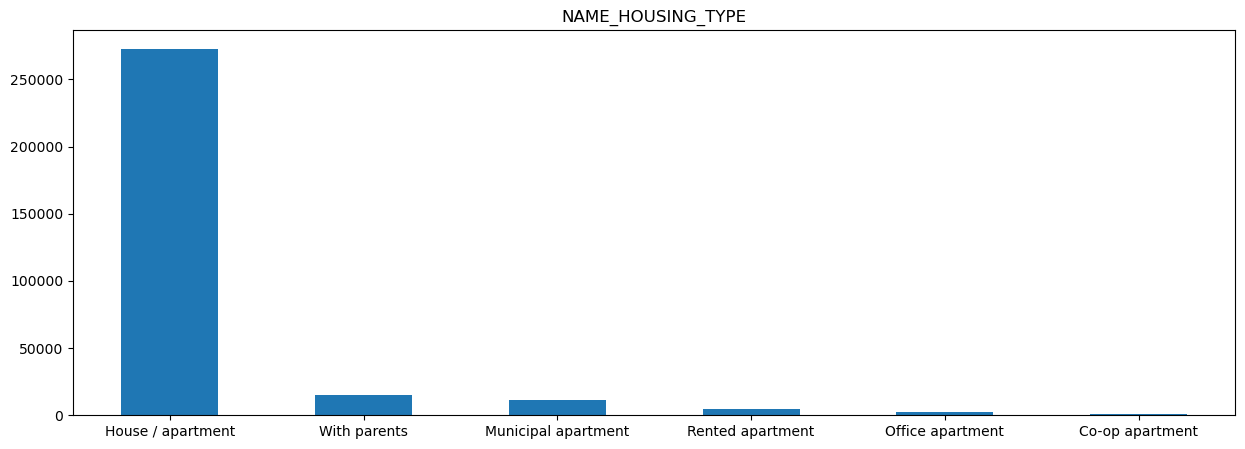

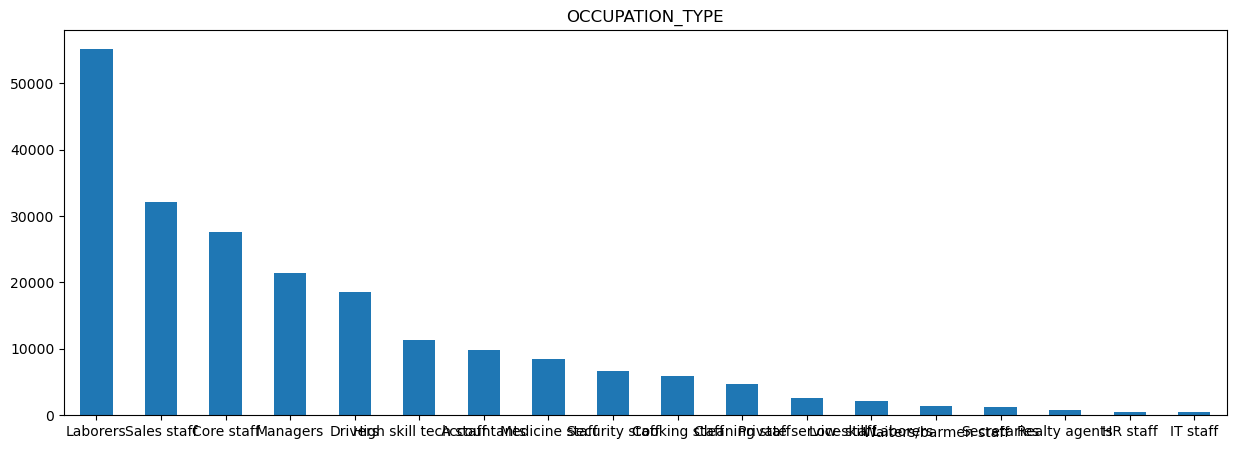

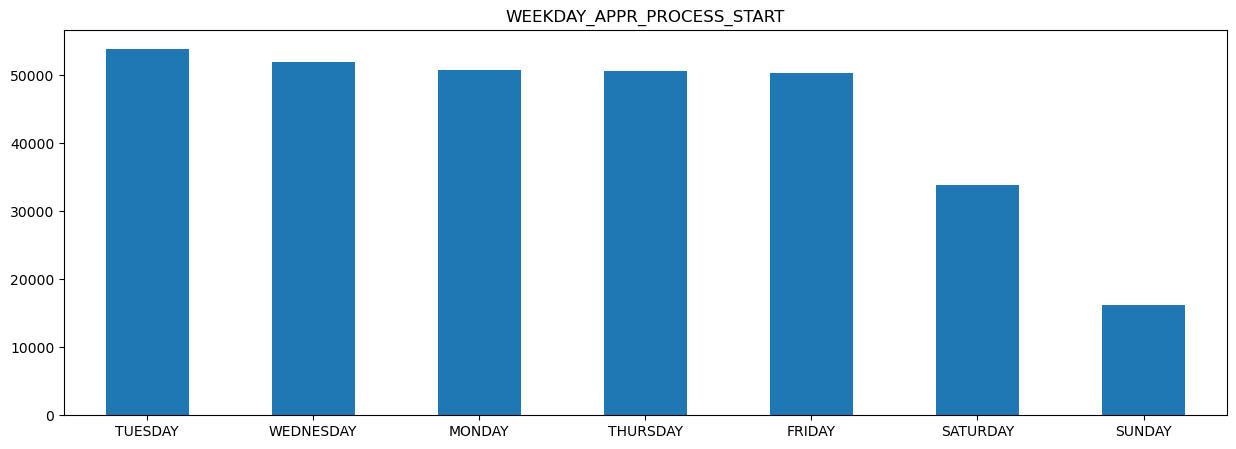

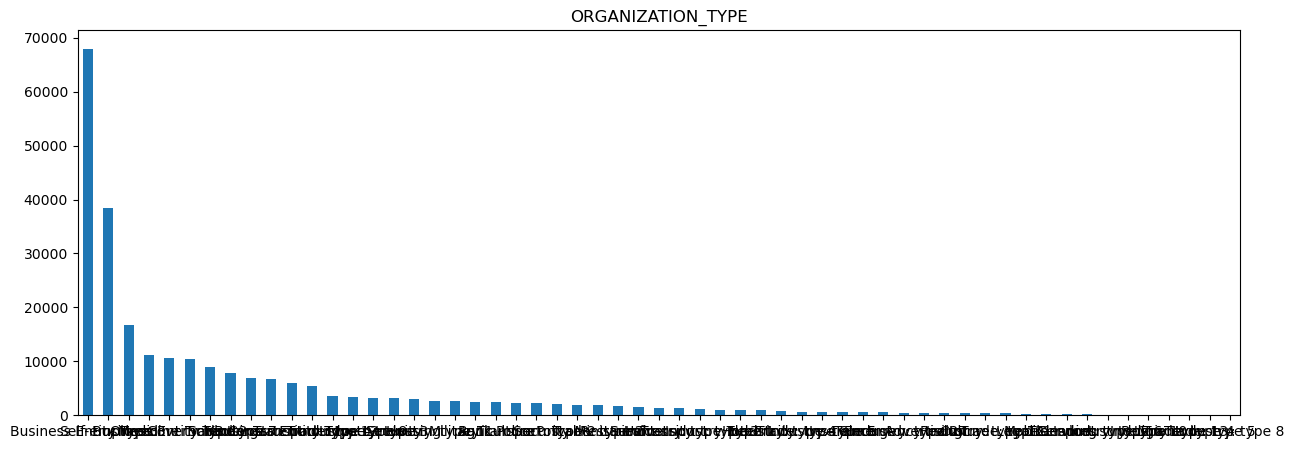

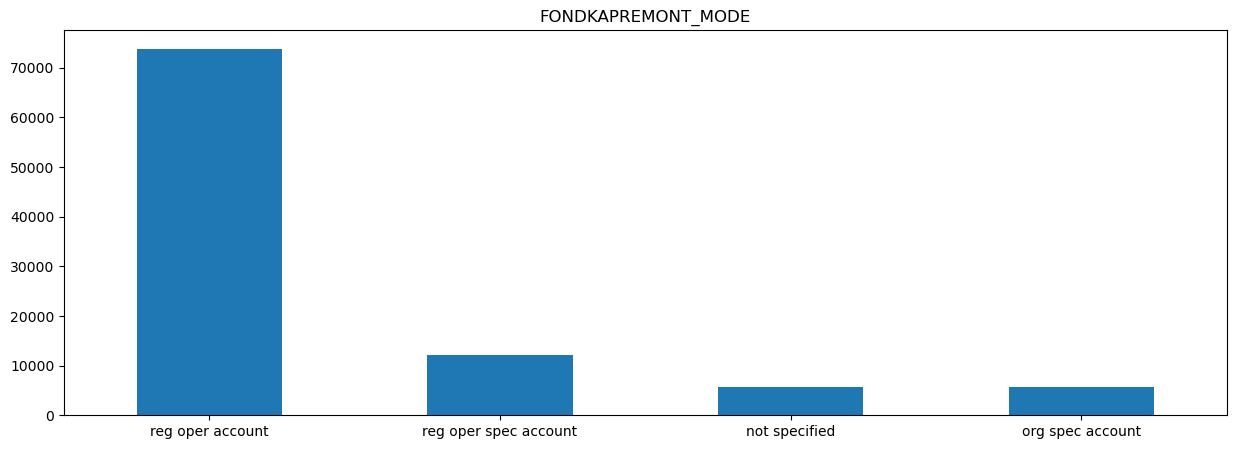

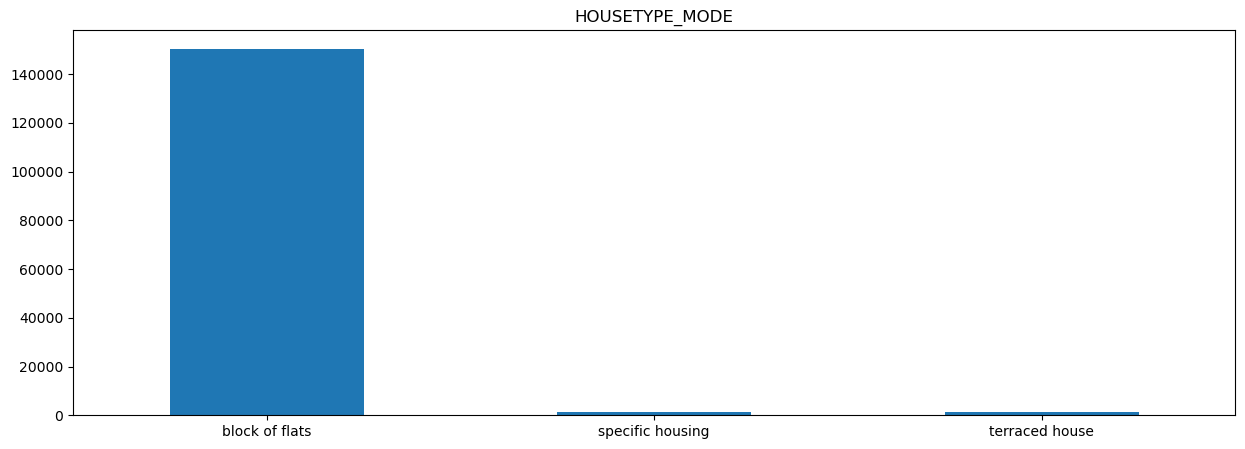

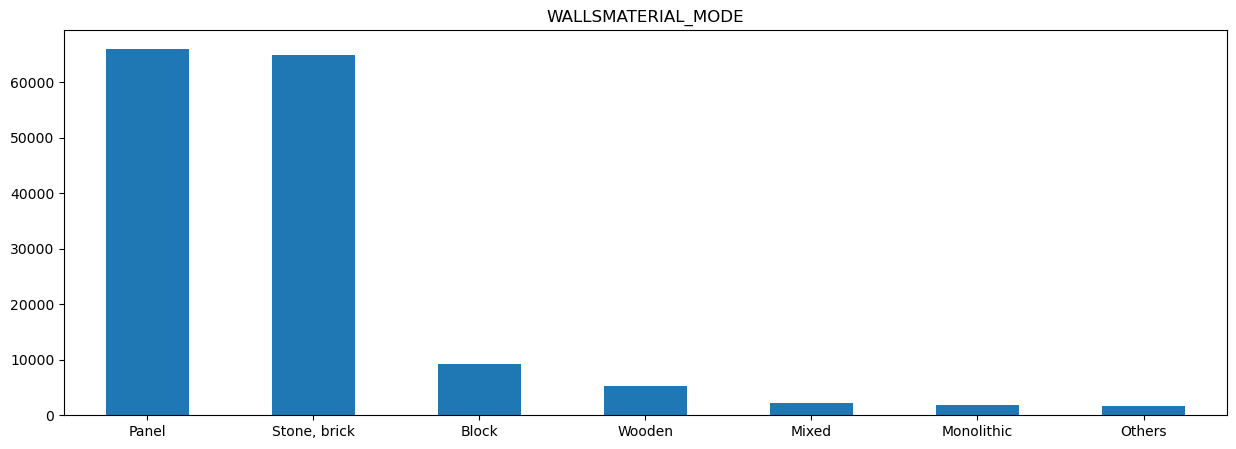

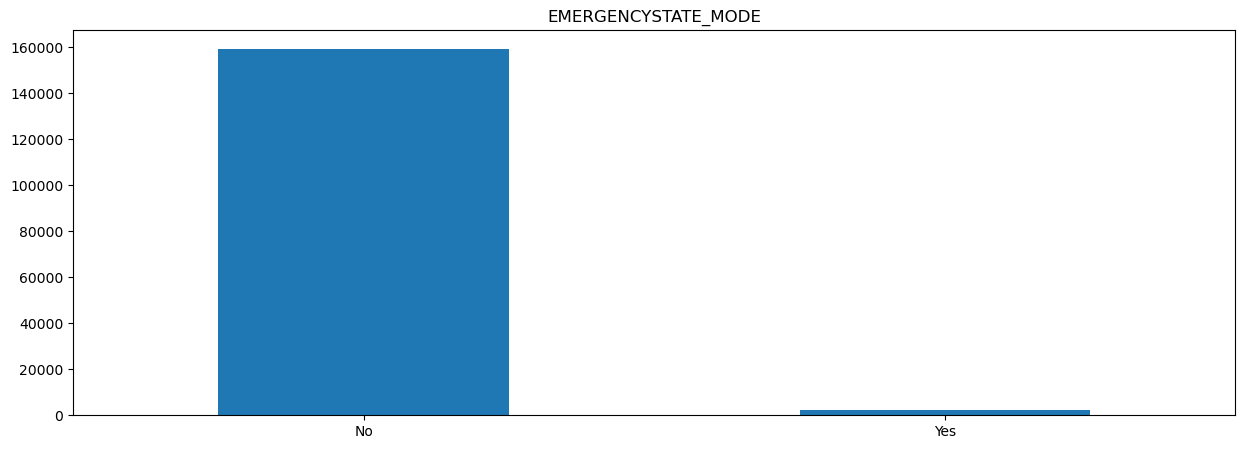

In [59]:
for s in categorical_columns:
   fig = plt.figure(figsize =(15,5))
   data[s].value_counts().plot(kind='bar', rot=0).set_title(s)
   plt.show()

## Correlation matrix

C:\Users\Maria\AppData\Local\Temp\ipykernel_11108\2475493157.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_data = data.corr()
C:\Users\Maria\AppData\Local\Temp\ipykernel_11108\2475493157.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_pivot = heatmap_data.pivot('Variable1', 'Variable2', 'Correlation')


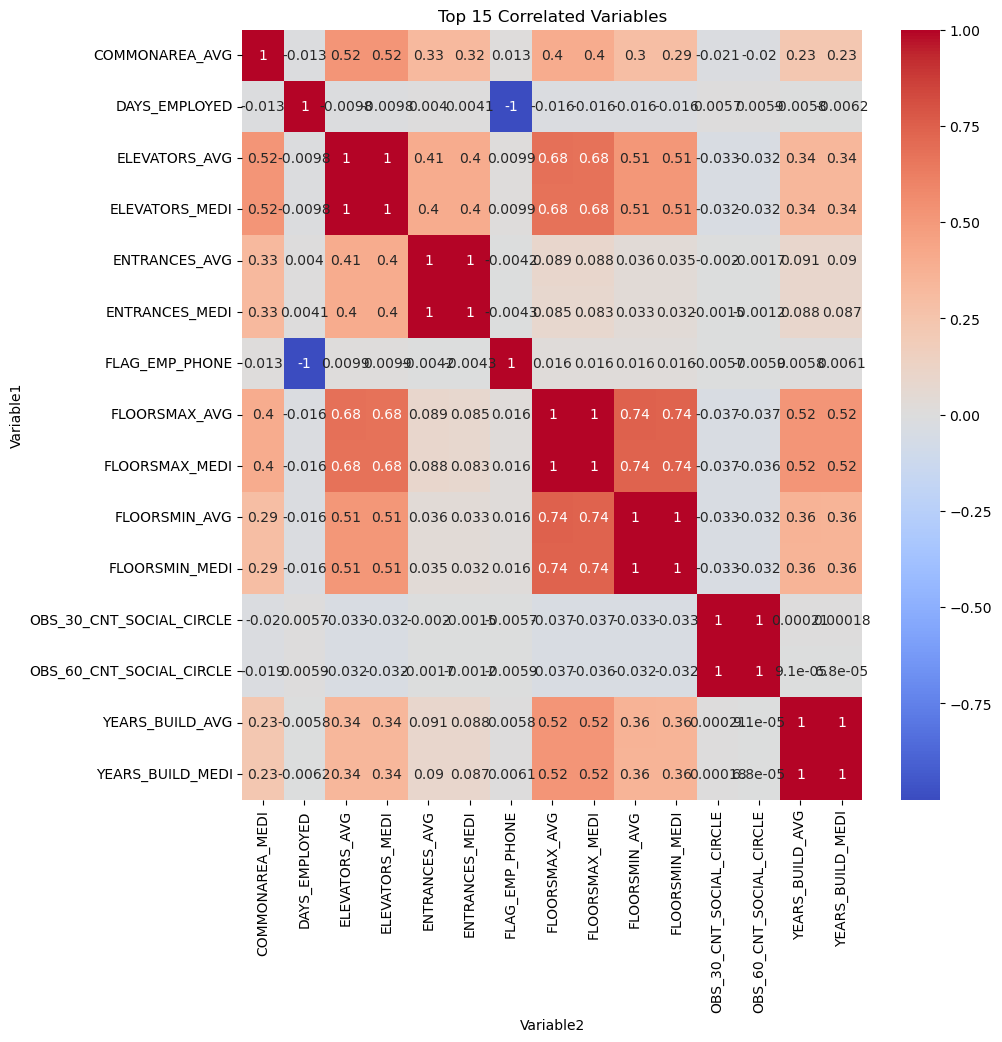

In [21]:
# Sample correlation data
correlation_data = data.corr()

# Get the top correlated variables
top_correlated = correlation_data.abs().unstack().sort_values(ascending=False).reset_index()
top_correlated = top_correlated[top_correlated['level_0'] != top_correlated['level_1']]

# Select the top N correlated variables
top_n = 15
top_correlated = top_correlated.head(top_n)

# Extract variable names
variable1 = top_correlated['level_0']
variable2 = top_correlated['level_1']

# Filter the correlation data based on top variables
filtered_data = correlation_data.loc[variable1, variable2]

# Reshape the filtered data for heatmap plotting
heatmap_data = filtered_data.unstack().reset_index()
heatmap_data.columns = ['Variable1', 'Variable2', 'Correlation']

# Create a pivot table for heatmap plot
heatmap_pivot = heatmap_data.pivot('Variable1', 'Variable2', 'Correlation')

# Create the heatmap plot
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_pivot, annot=True, cmap='coolwarm')
plt.title(f'Top {top_n} Correlated Variables')
plt.show()

## box plots 

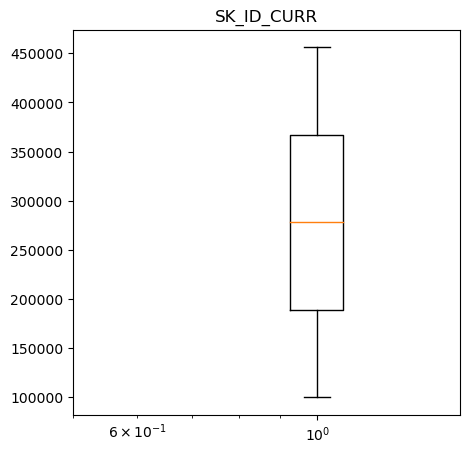

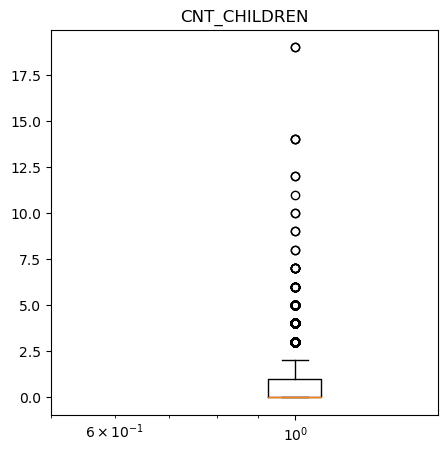

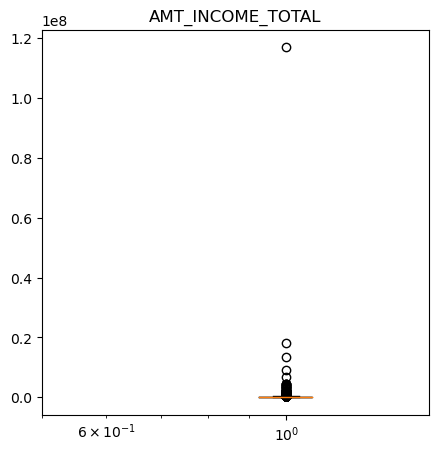

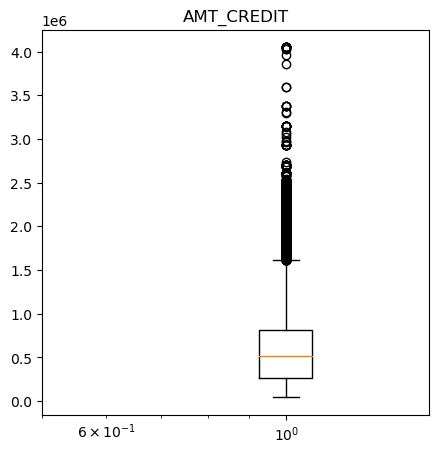

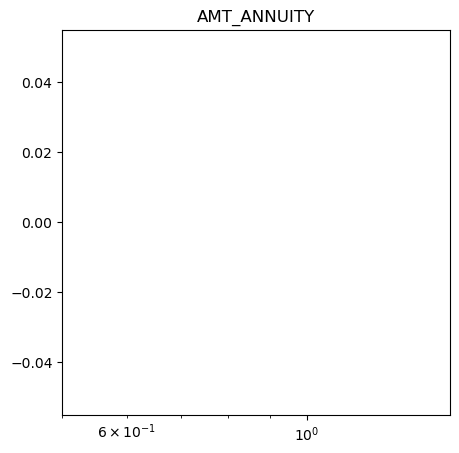

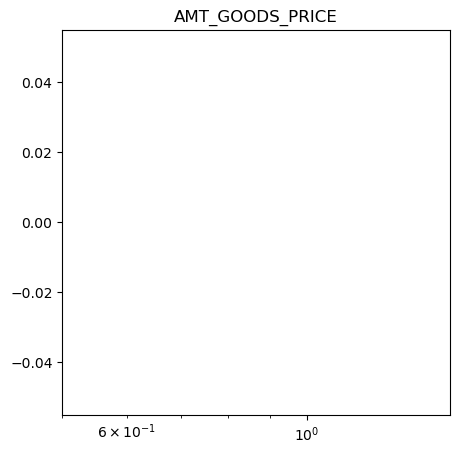

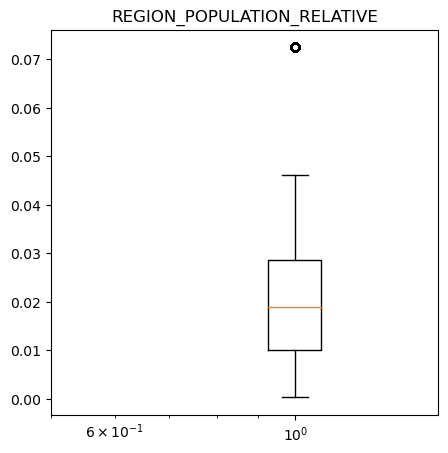

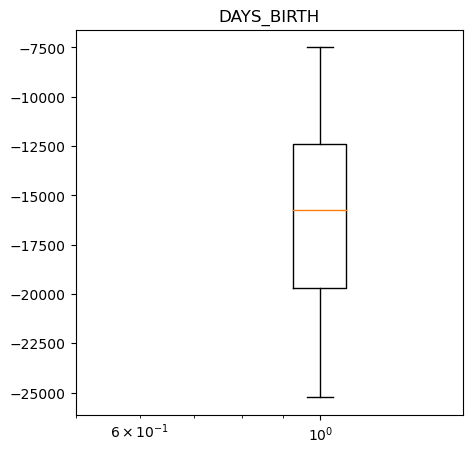

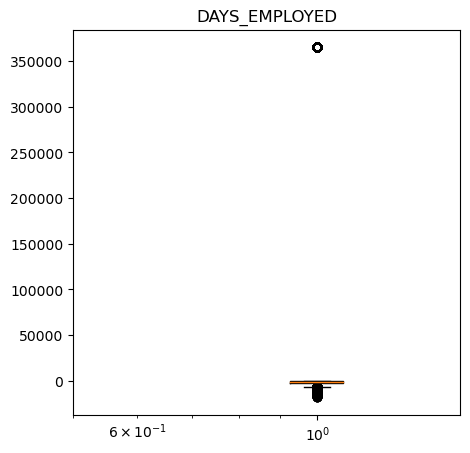

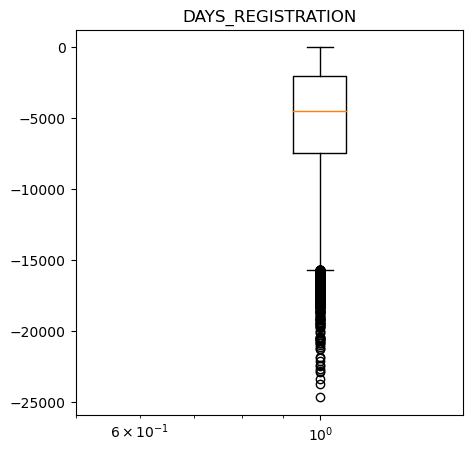

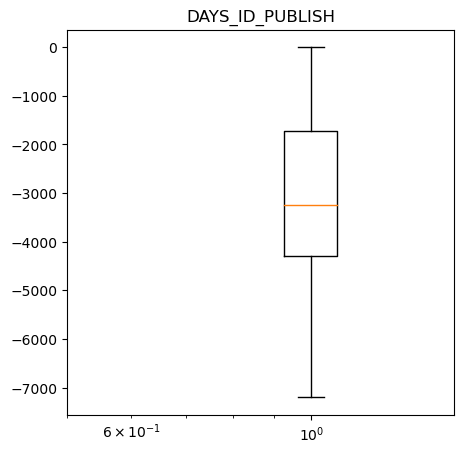

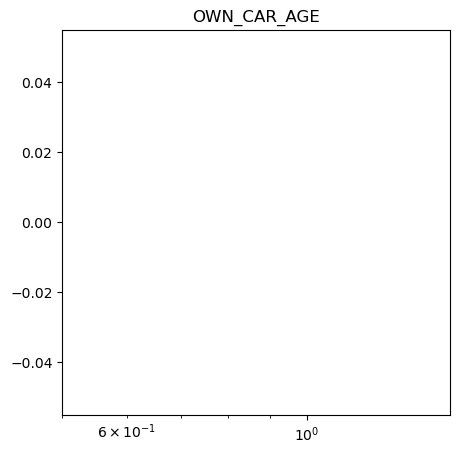

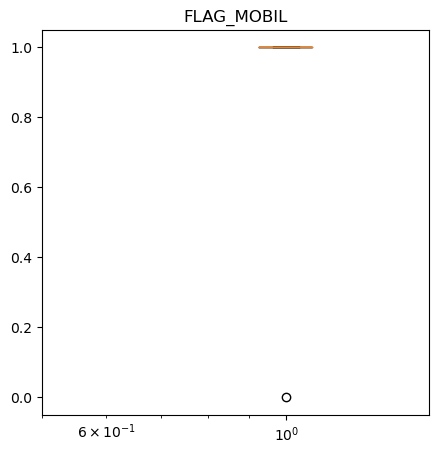

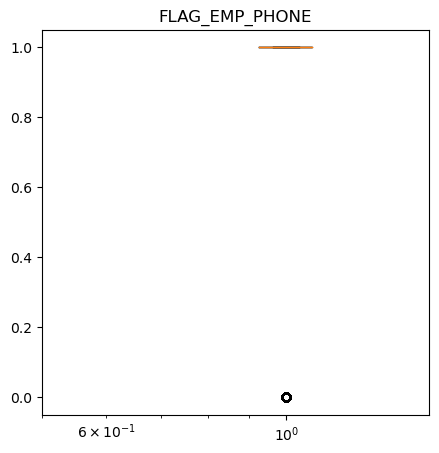

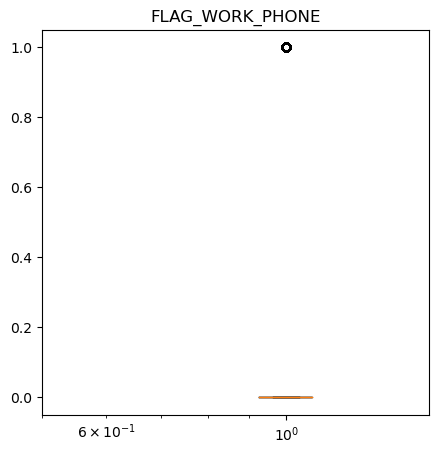

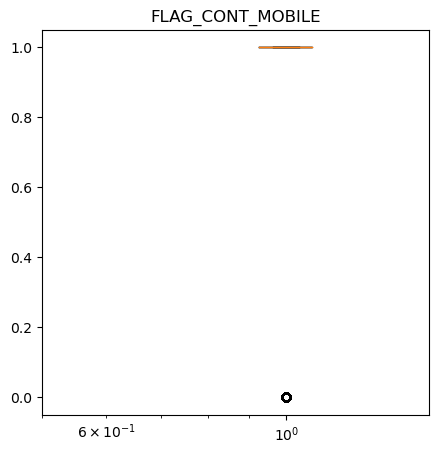

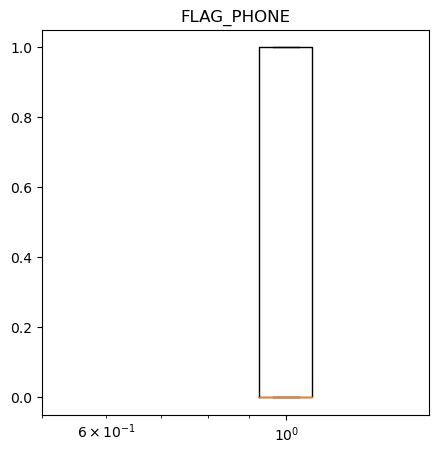

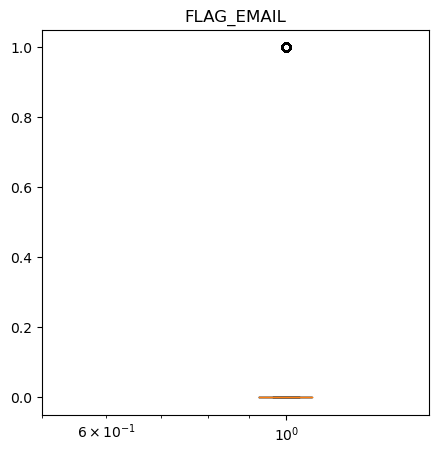

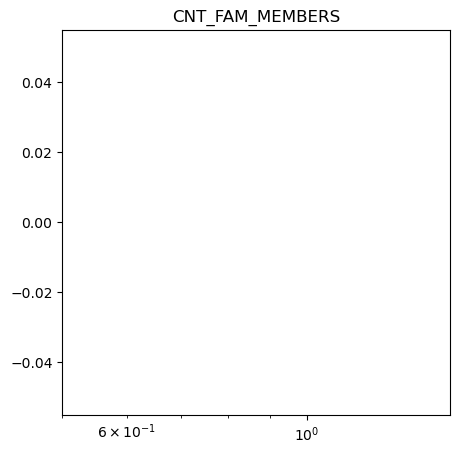

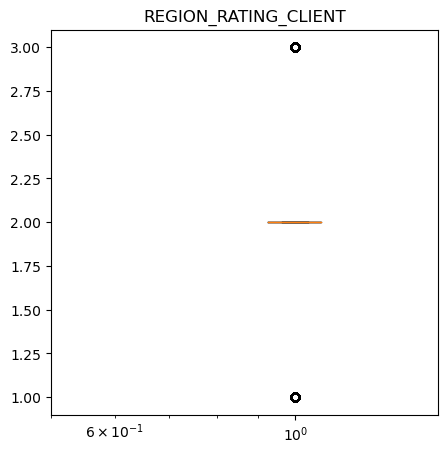

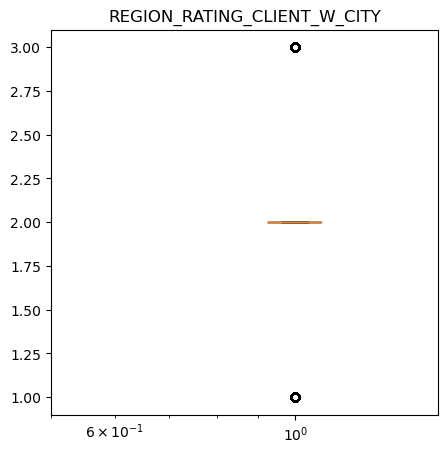

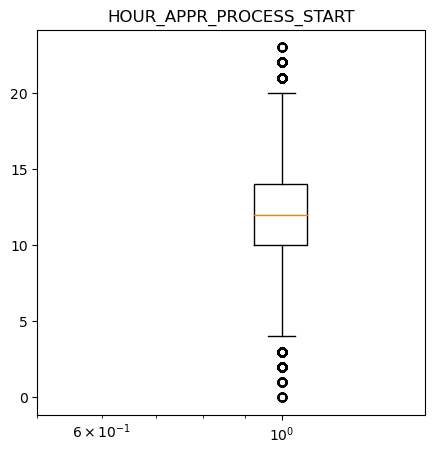

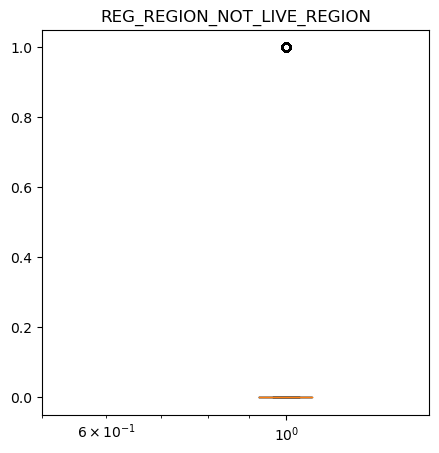

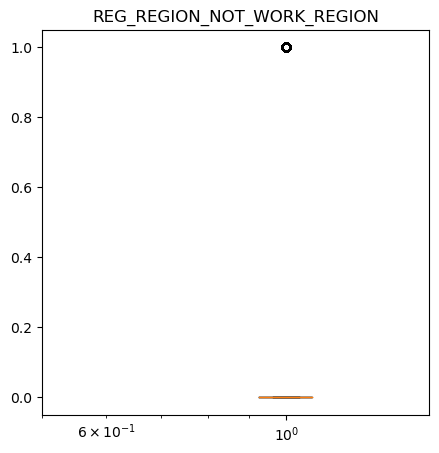

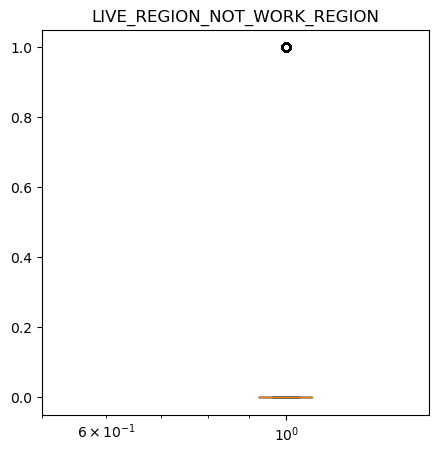

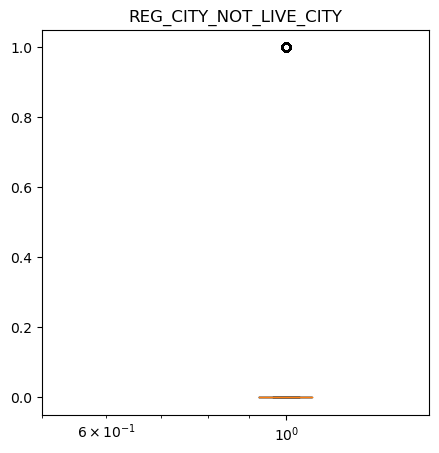

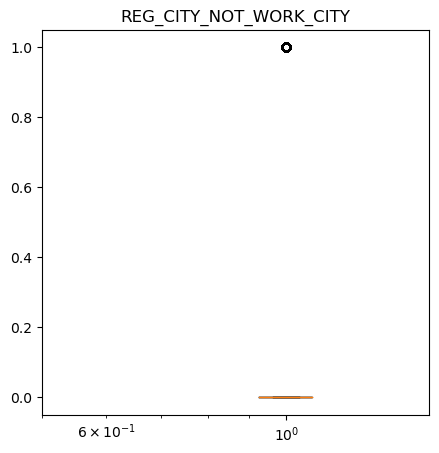

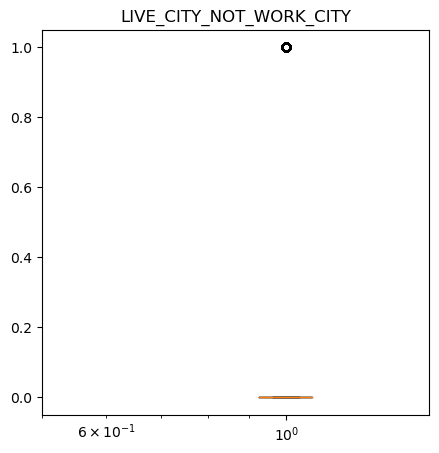

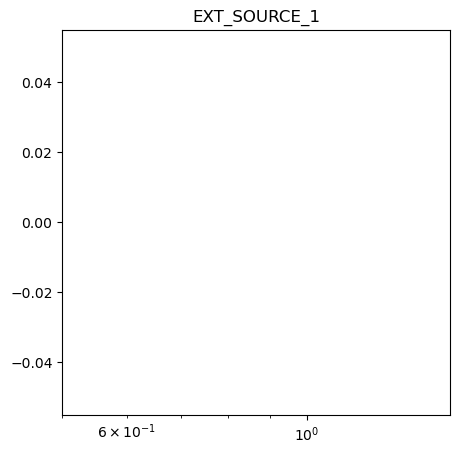

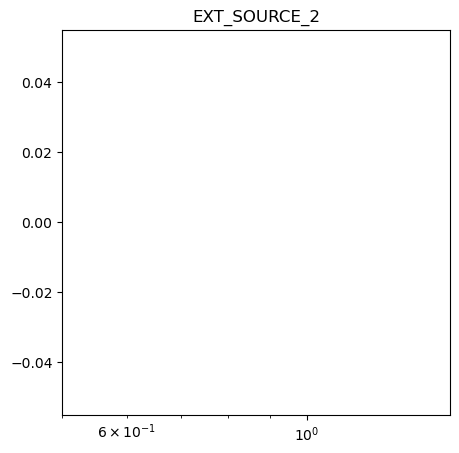

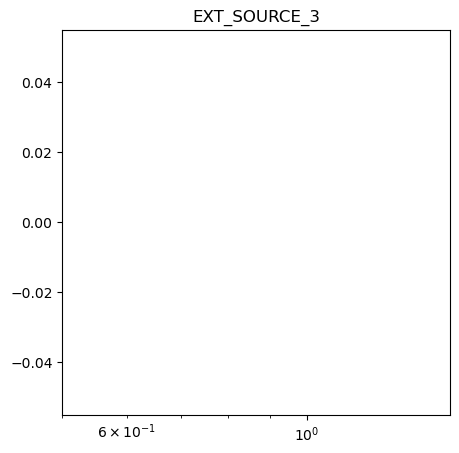

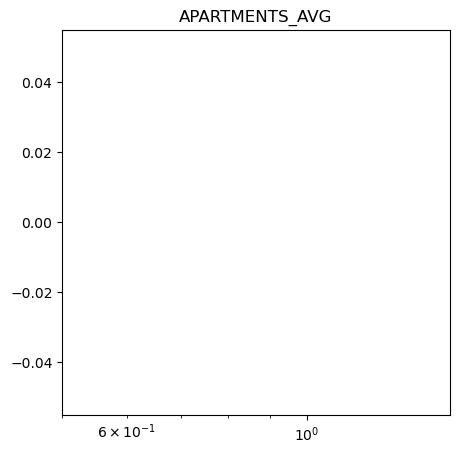

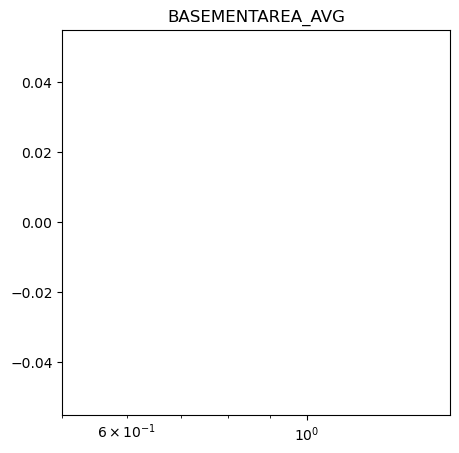

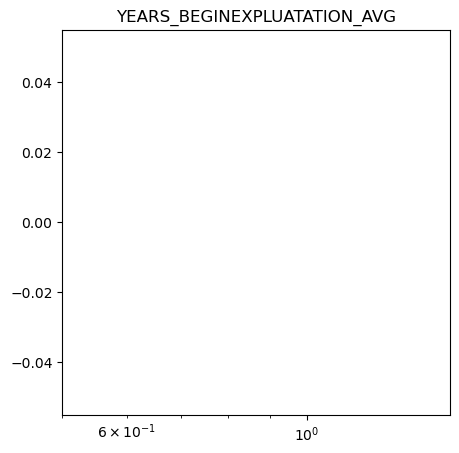

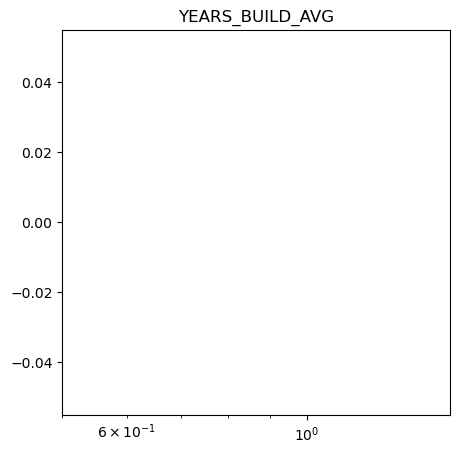

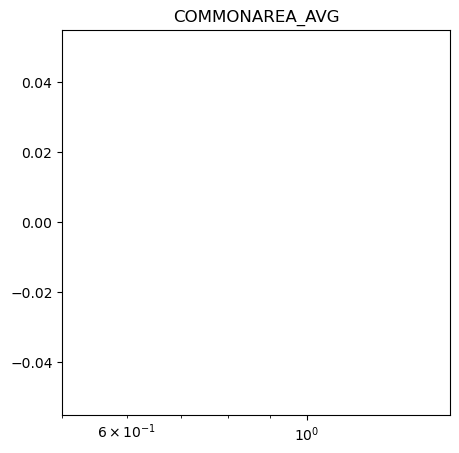

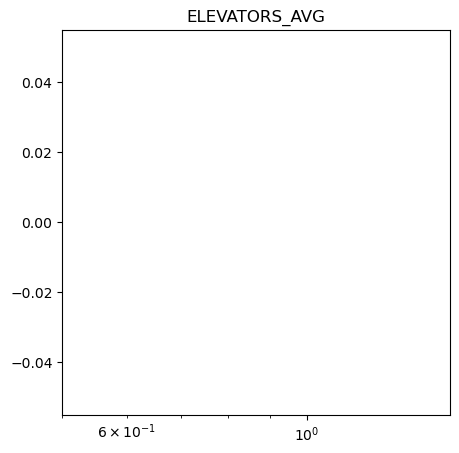

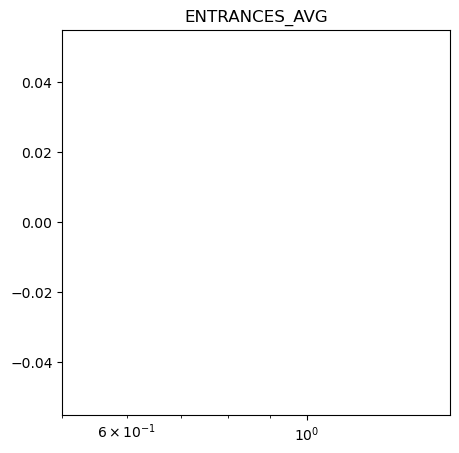

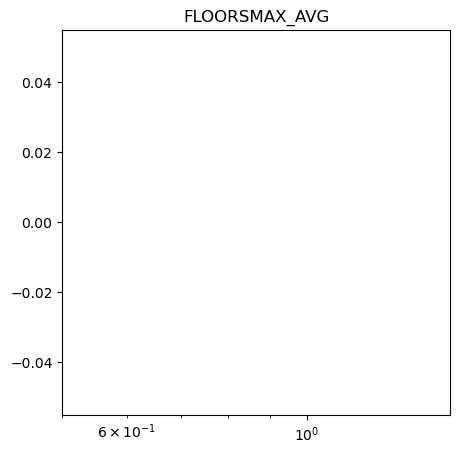

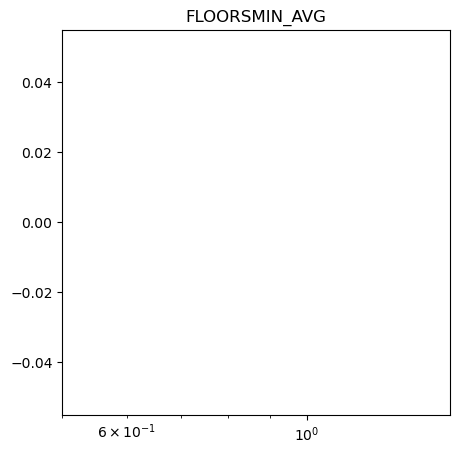

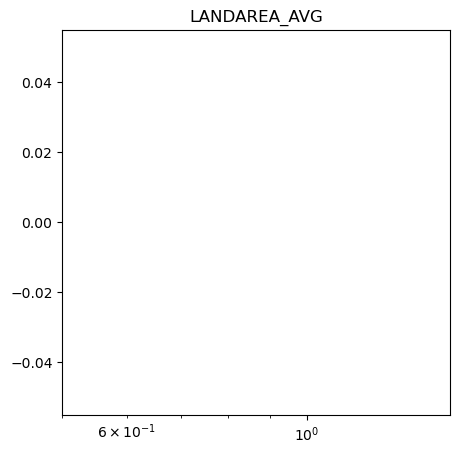

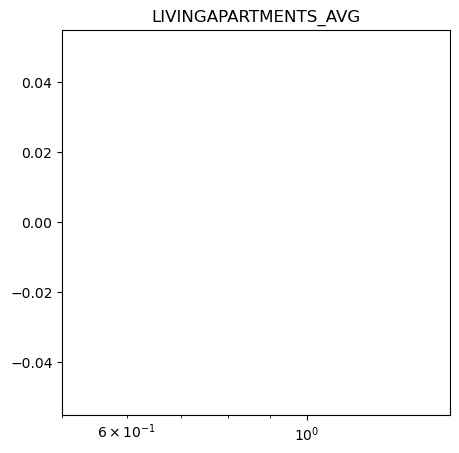

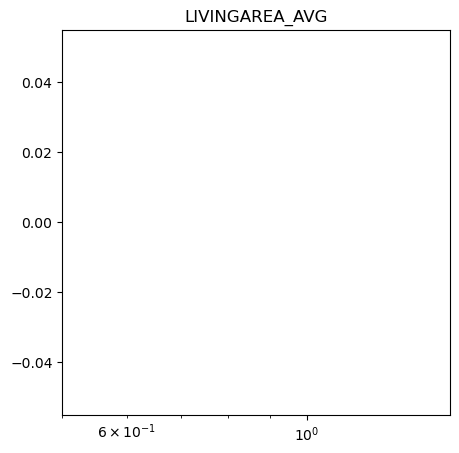

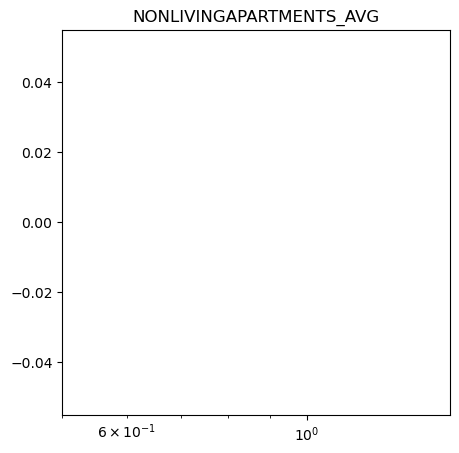

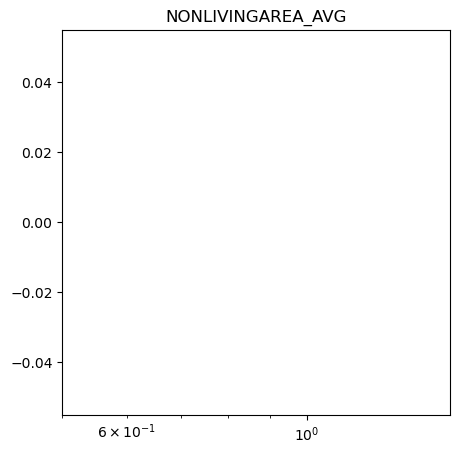

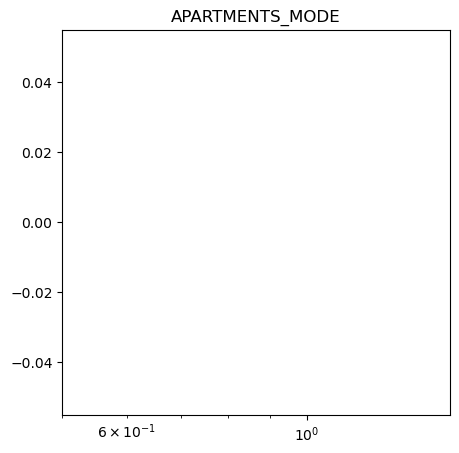

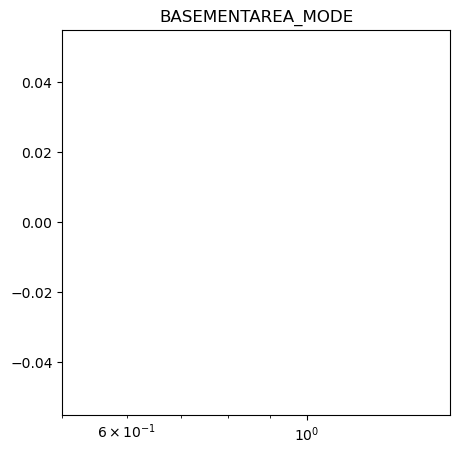

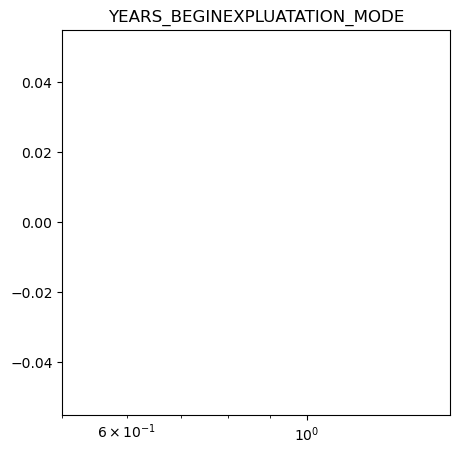

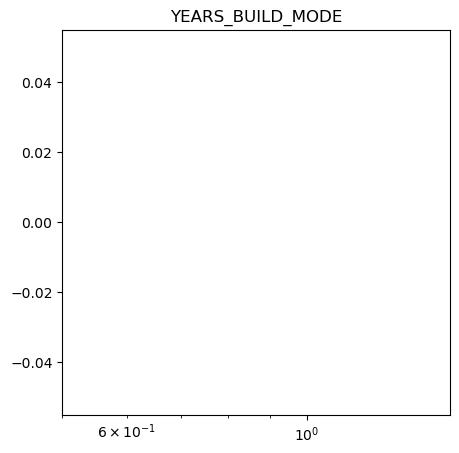

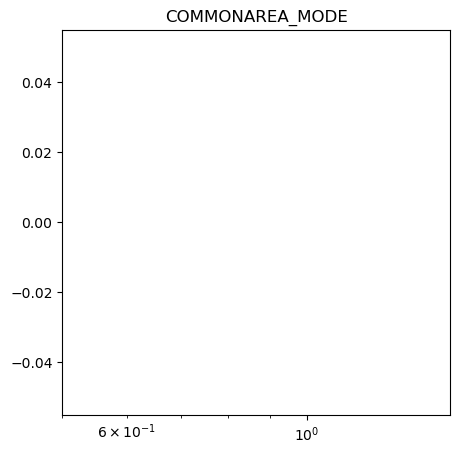

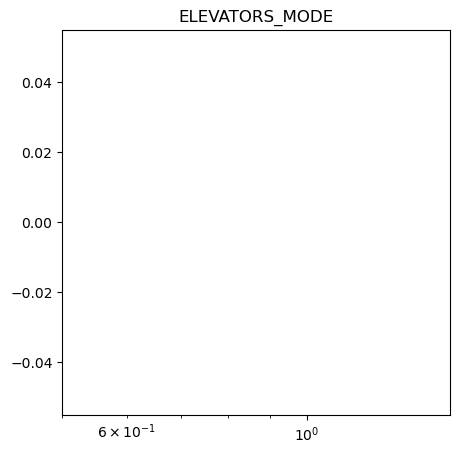

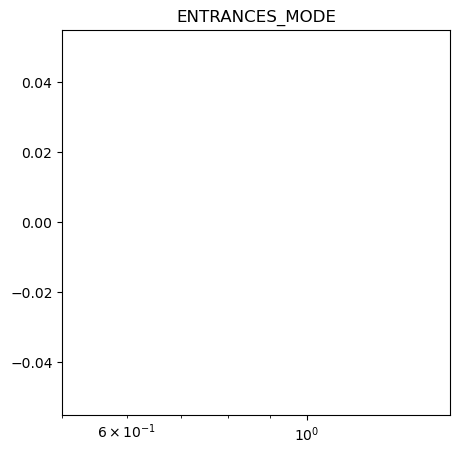

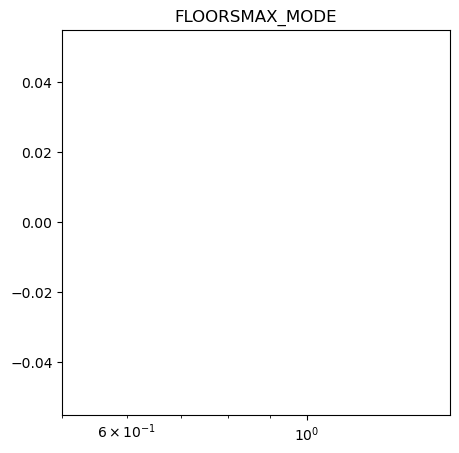

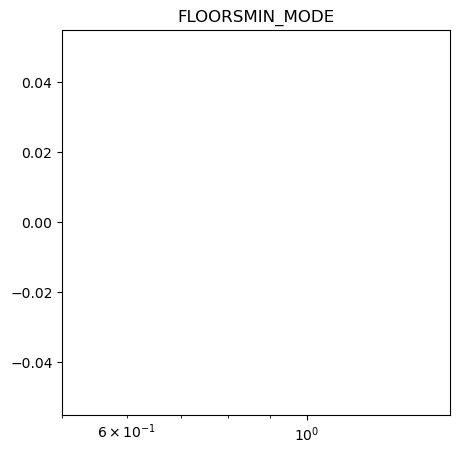

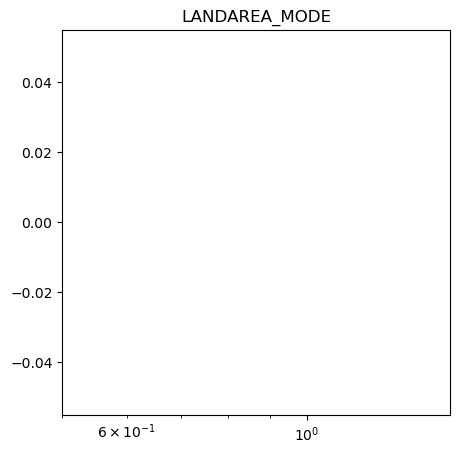

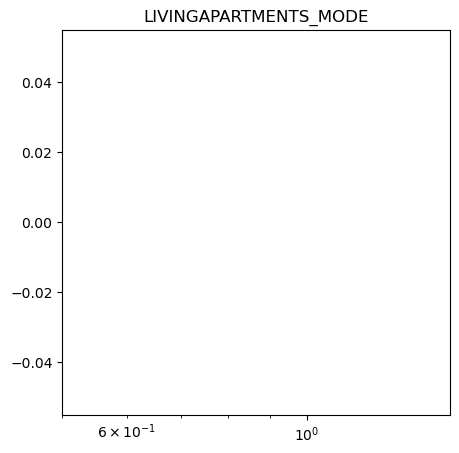

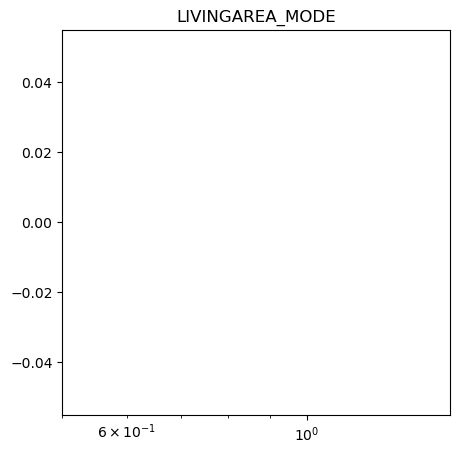

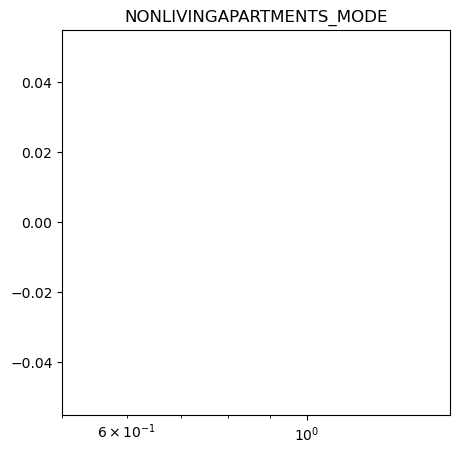

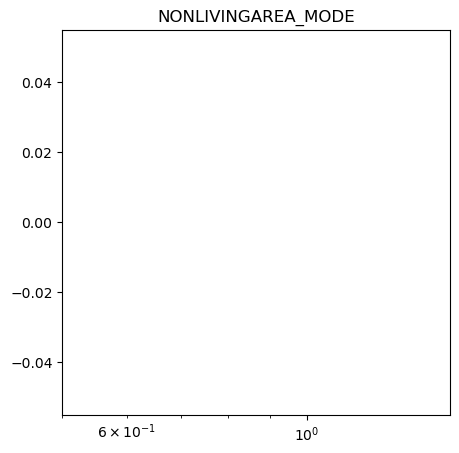

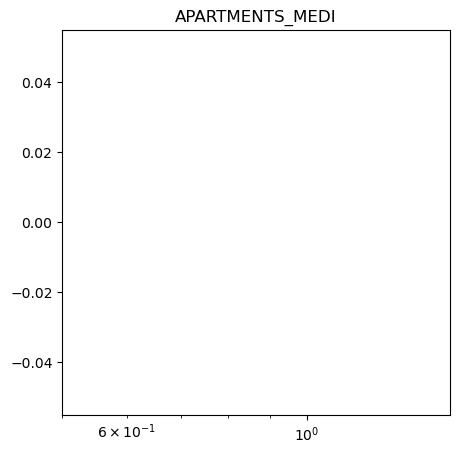

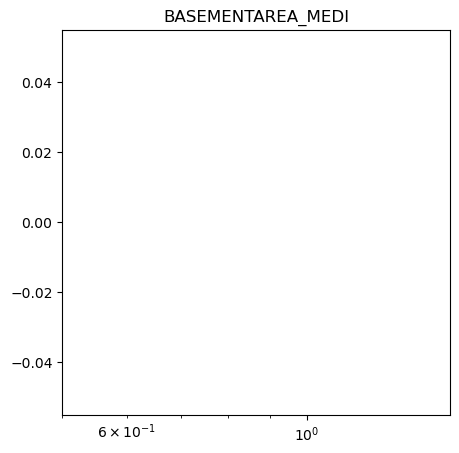

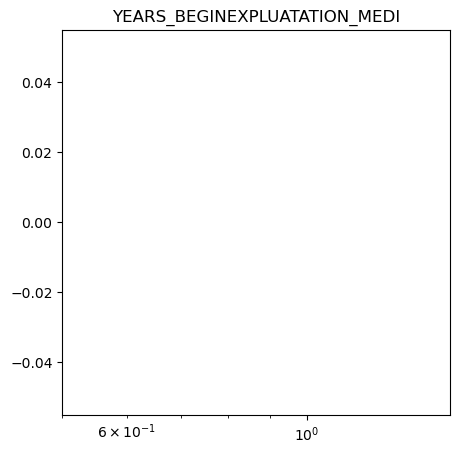

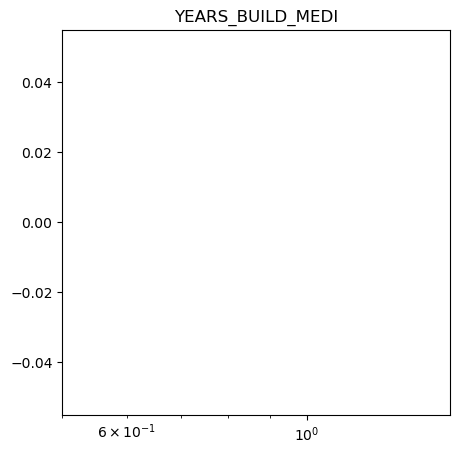

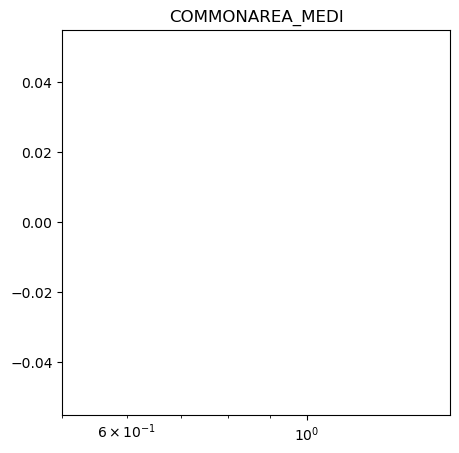

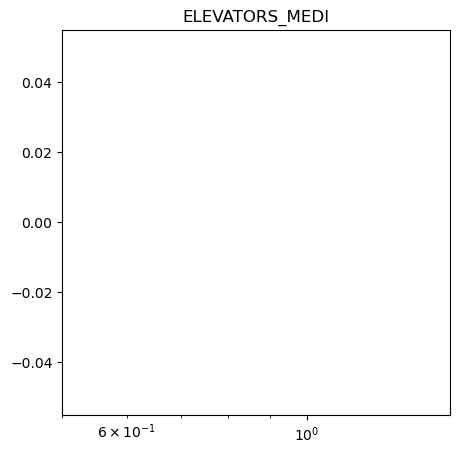

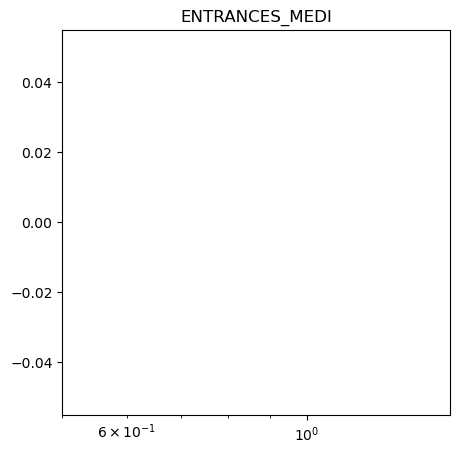

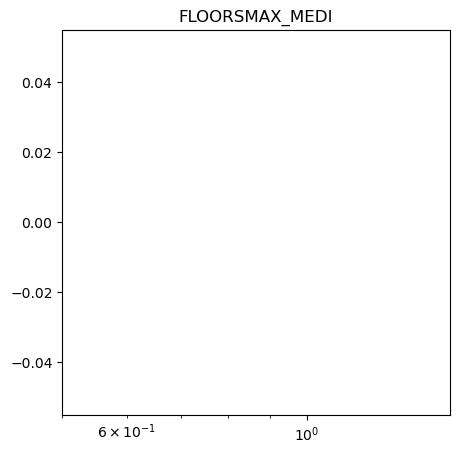

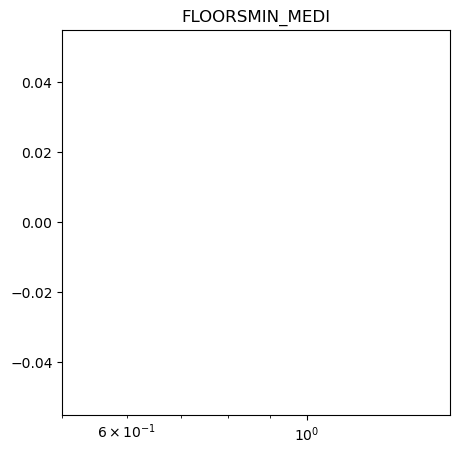

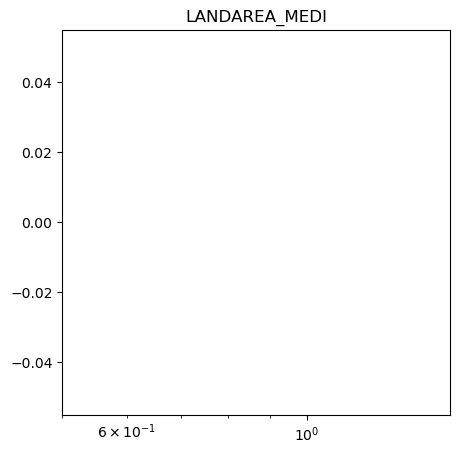

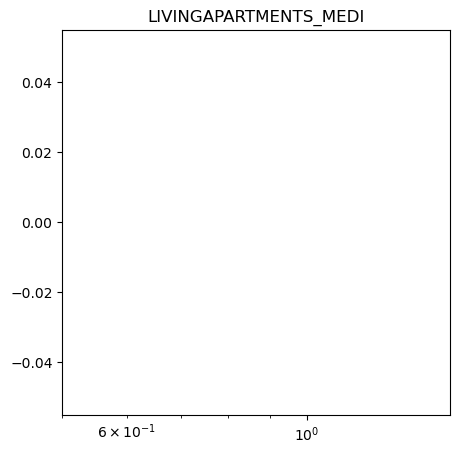

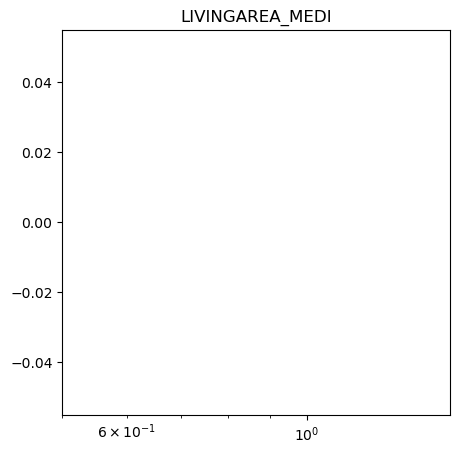

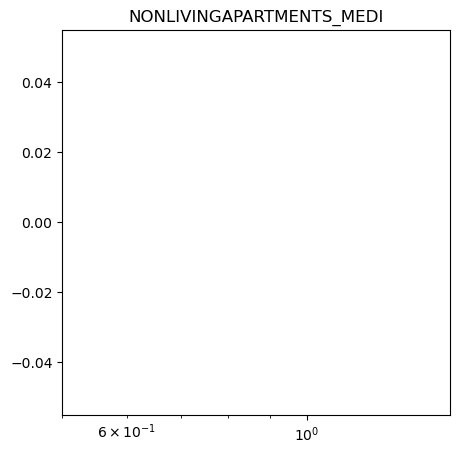

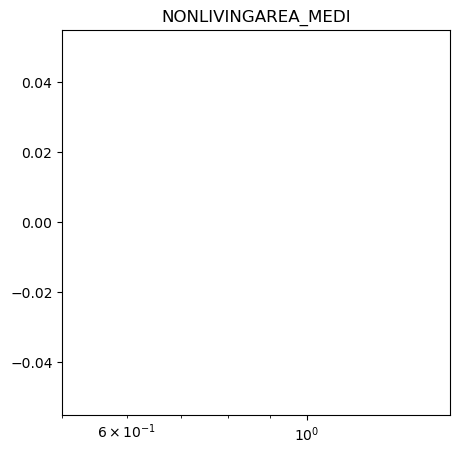

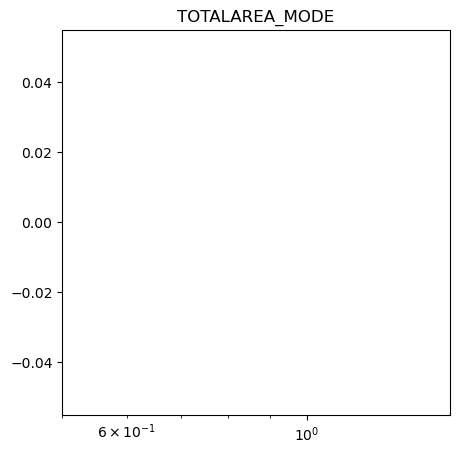

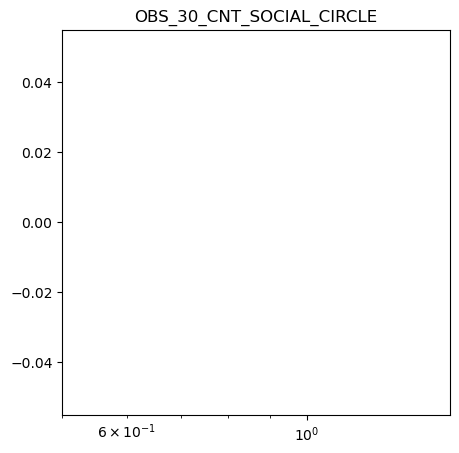

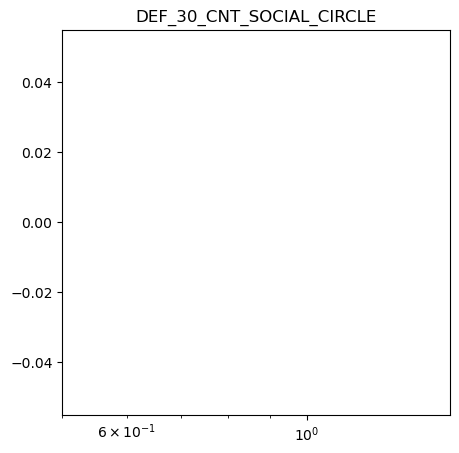

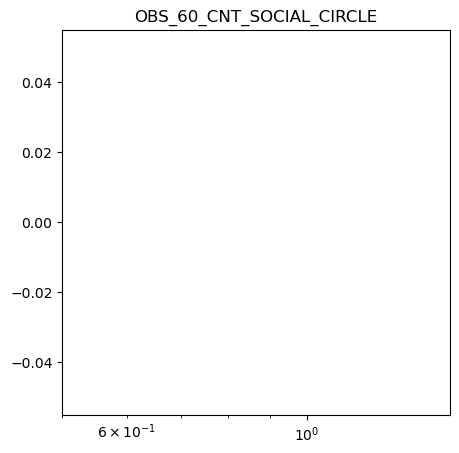

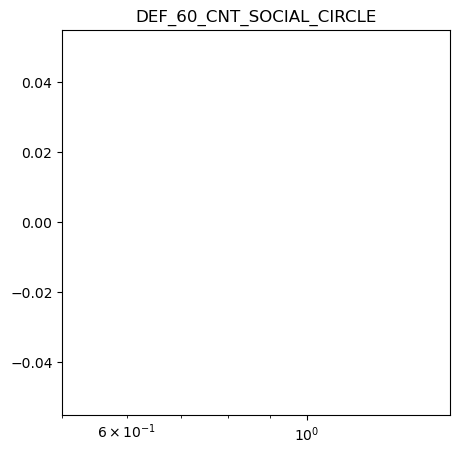

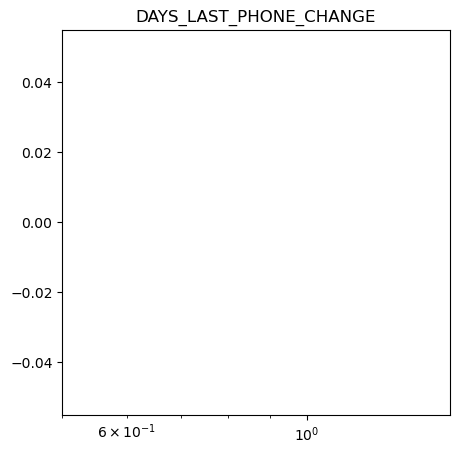

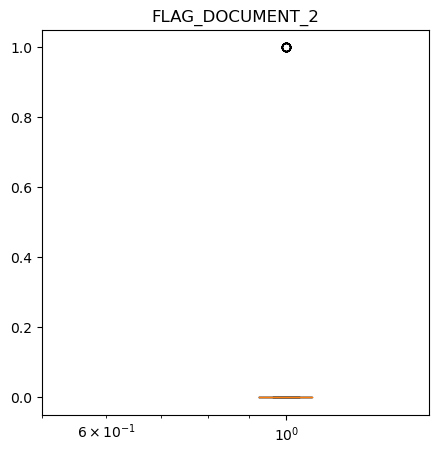

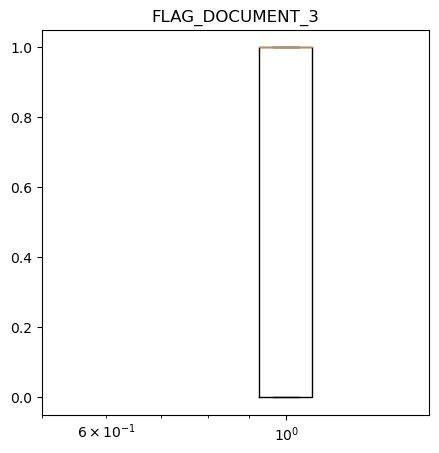

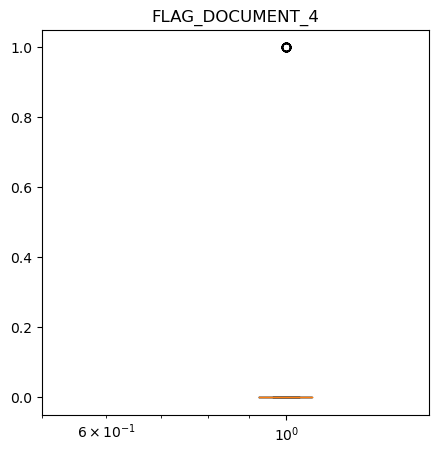

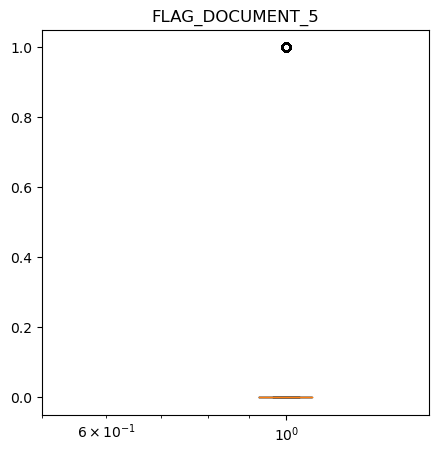

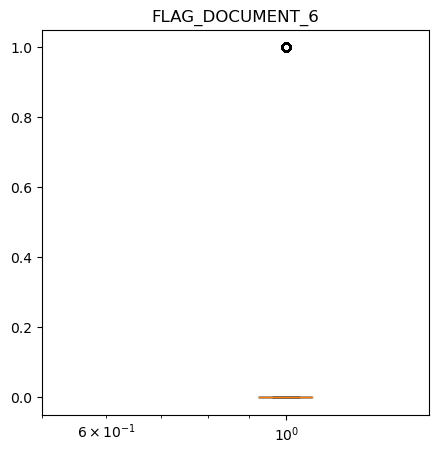

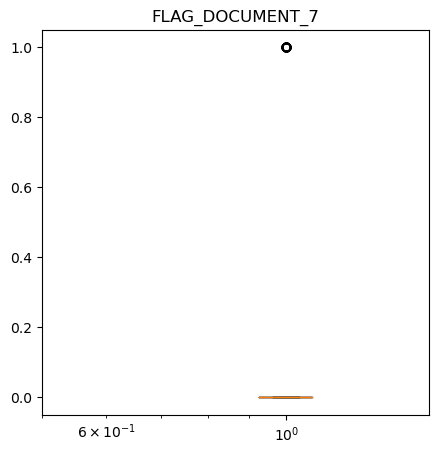

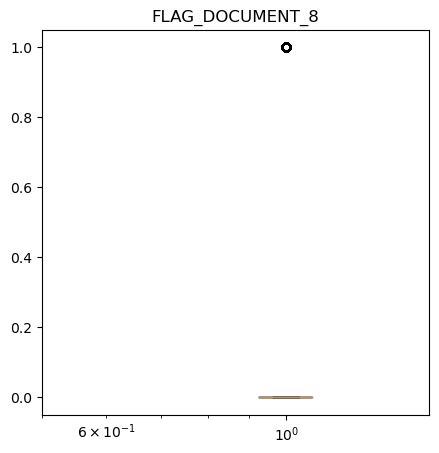

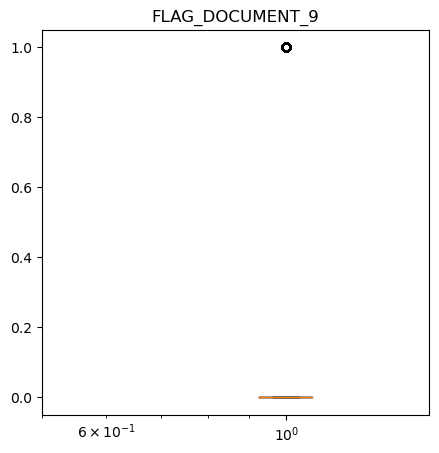

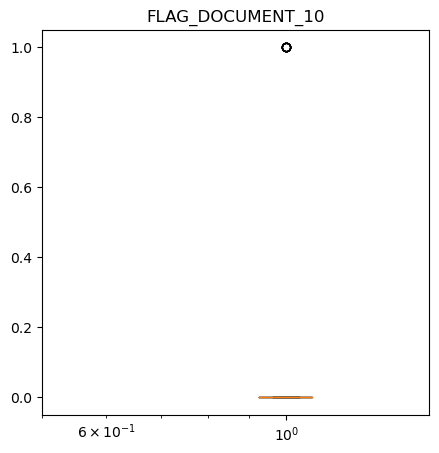

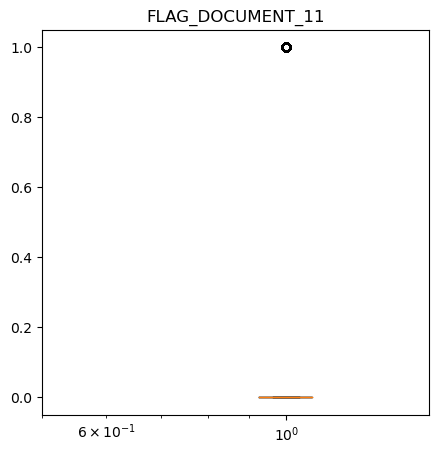

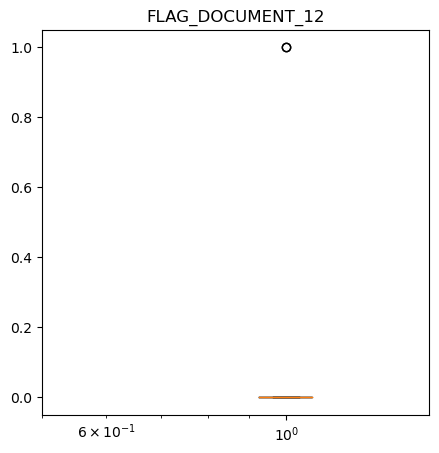

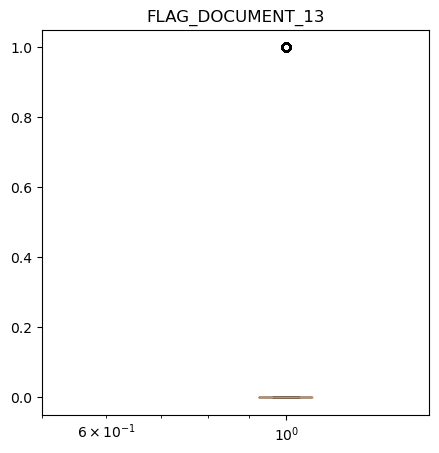

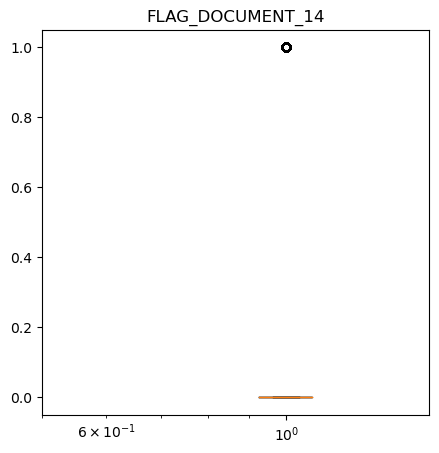

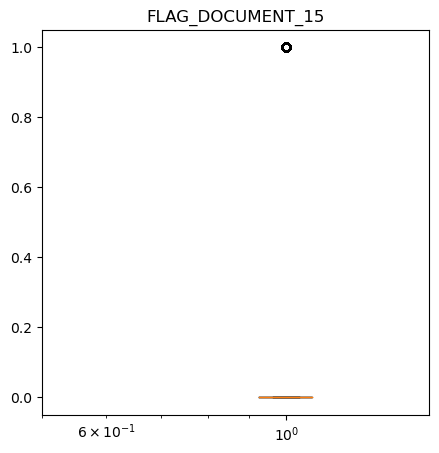

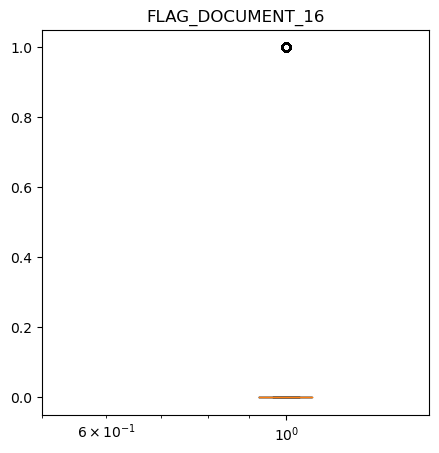

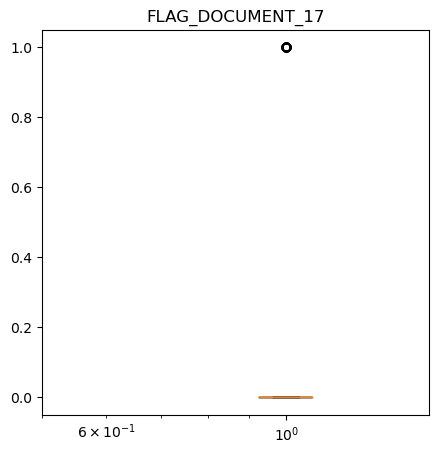

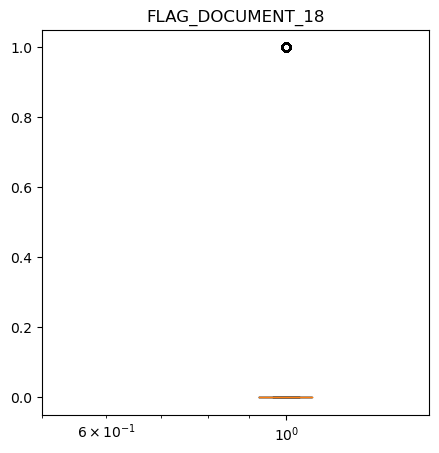

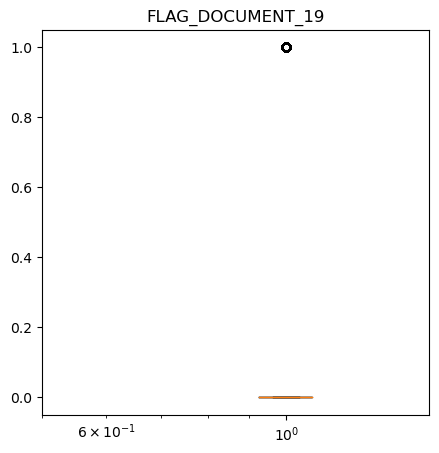

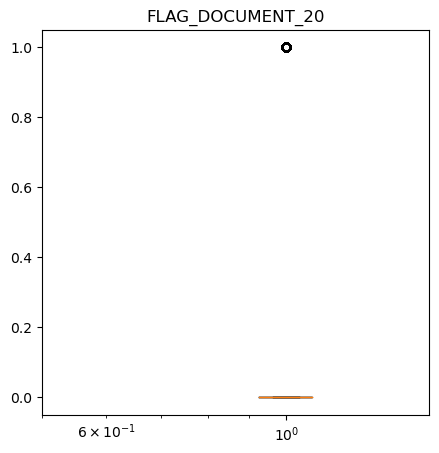

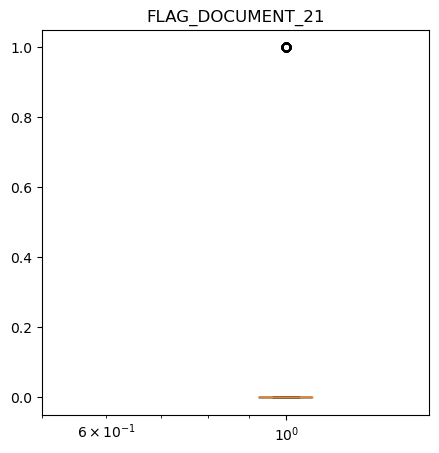

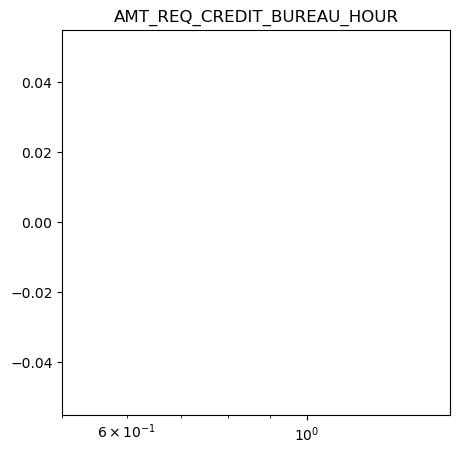

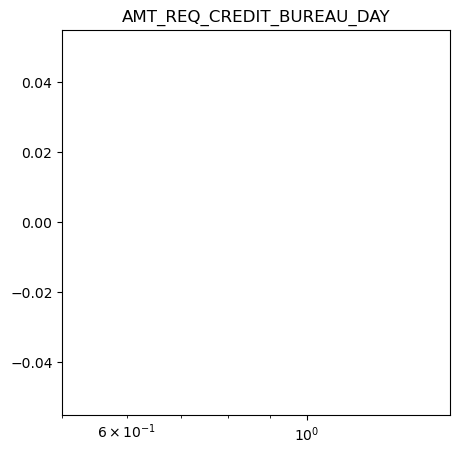

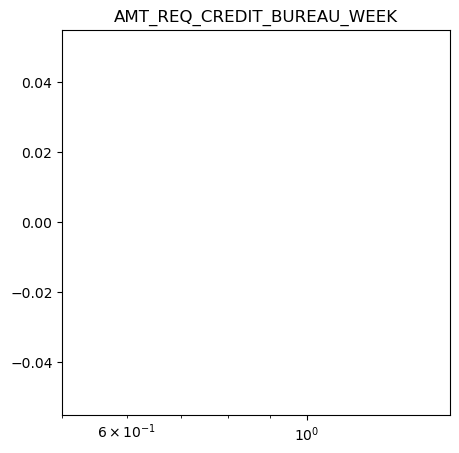

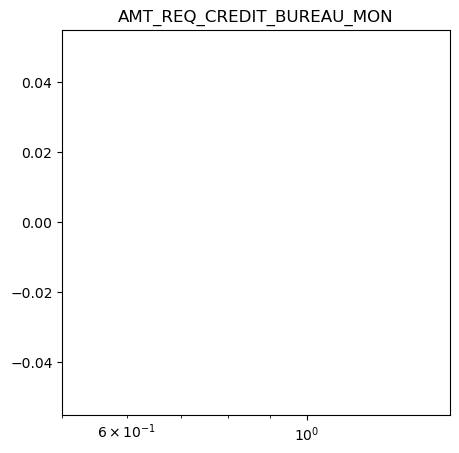

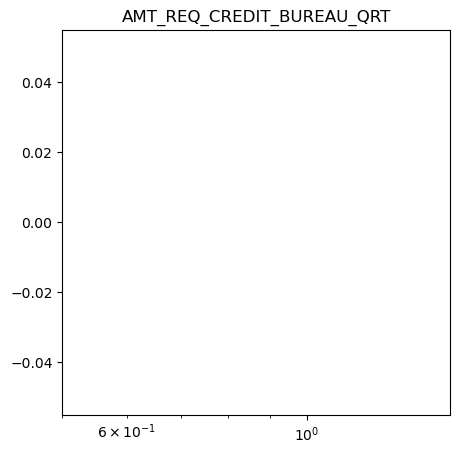

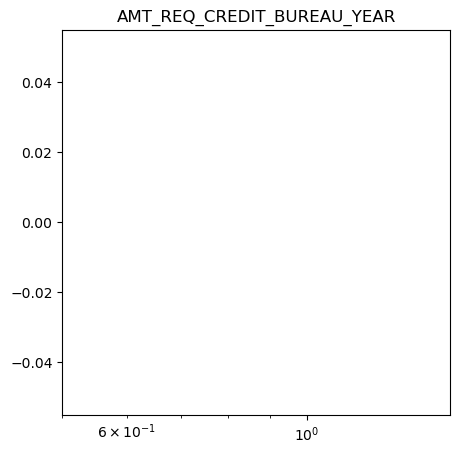

In [23]:
for s in numerical_columns:
   fig = plt.figure(figsize =(5,5))
   plt.boxplot(data[s])
   plt.xscale('log')
   plt.title(s)
   plt.show()
   

## Try to know if this are really an outliers or not


In [24]:
for s in numerical_columns:
    q25, q75 = percentile(x_train[s], 25), percentile(x_train[s], 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    print(s)
    outliers = [x for x in x_train[s] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in x_train[s] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    print()


SK_ID_CURR
Identified outliers: 0
Non-outlier observations: 246008

CNT_CHILDREN
Identified outliers: 3366
Non-outlier observations: 242642

AMT_INCOME_TOTAL
Identified outliers: 11247
Non-outlier observations: 234761

AMT_CREDIT
Identified outliers: 5260
Non-outlier observations: 240748

AMT_ANNUITY
Identified outliers: 5987
Non-outlier observations: 240021

AMT_GOODS_PRICE
Identified outliers: 11791
Non-outlier observations: 234217

REGION_POPULATION_RELATIVE
Identified outliers: 6729
Non-outlier observations: 239279

DAYS_BIRTH
Identified outliers: 0
Non-outlier observations: 246008

DAYS_EMPLOYED
Identified outliers: 57668
Non-outlier observations: 188340

DAYS_REGISTRATION
Identified outliers: 543
Non-outlier observations: 245465

DAYS_ID_PUBLISH
Identified outliers: 0
Non-outlier observations: 246008

OWN_CAR_AGE
Identified outliers: 79597
Non-outlier observations: 166411

FLAG_MOBIL
Identified outliers: 1
Non-outlier observations: 246007

FLAG_EMP_PHONE
Identified outliers: 4415

In [25]:

columns_of_interest = ['CNT_CHILDREN']

# Subset the data based on the selected columns
subset_data = x_train[columns_of_interest]

# Create LOF object
lof = LocalOutlierFactor(n_neighbors=5)

# Fit the subset data and predict outliers
outlier_scores = lof.fit_predict(subset_data)

# Determine if each column contains outliers or not
outliers_present = outlier_scores < 0
outliers_absent = outlier_scores >= 0

# Print the results
for column, outliers in zip(columns_of_interest, outliers_present):
    if outliers.any():
        print(f"{column} contains outliers.")
    else:
        print(f"{column} does not contain outliers.")



CNT_CHILDREN does not contain outliers.


In [26]:
columns_of_interest = ['AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_EMPLOYED','REGION_POPULATION_RELATIVE','DAYS_REGESTRATION']

# Subset the data based on the selected columns
subset_data = x_train[columns_of_interest]

# Create LOF object
lof = LocalOutlierFactor()

# Fit the subset data and predict outliers
outlier_scores = lof.fit_predict(subset_data)

# Determine if each column contains outliers or not
outliers_present = outlier_scores < 0
outliers_absent = outlier_scores >= 0

# Print the results
for column, outliers in zip(columns_of_interest, outliers_present):
    if outliers.any():
        print(f"{column} contains outliers.")
    else:
        print(f"{column} does not contain outliers.")

KeyError: "['DAYS_REGESTRATION'] not in index"

In [ ]:
columns_of_interest = ['AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_EMPLOYED']

# Create One-Class SVM object
svm = OneClassSVM(nu=0.05)

# Loop through the columns and detect outliers
for column in columns_of_interest:
    column_data = x_train[column].values.reshape(-1, 1)  # Reshape the column data
    svm.fit(column_data)  # Fit One-Class SVM on the column data
    outlier_labels = svm.predict(column_data)  # Predict outlier labels

    if -1 in outlier_labels:
        print(f"{column} contains outliers.")
    else:
        print(f"{column} does not contain outliers.")

 AMT_ANNUITY, AMT_APPLICATION, AMT_CREDIT, AMT_GOODS_PRICE, SELLERPLACE_AREA , CNT_ CHILDERN have huge number of outliers.\
 CNT_PAYMENT has few outlier values.\
SK_ID_CURR is an ID column and hence no outliers.

## Feature Engineering and Selection

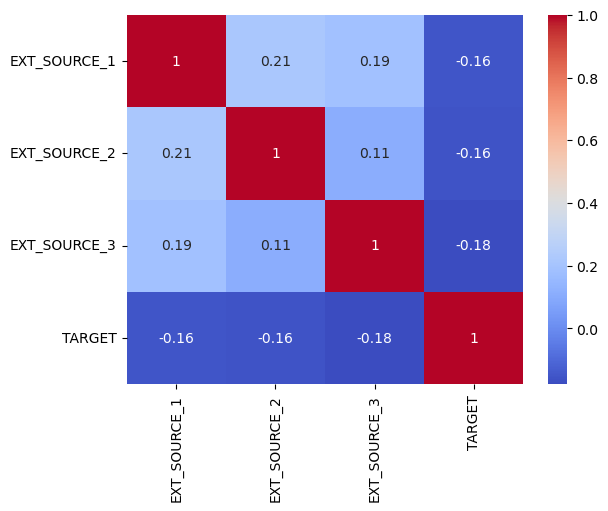

In [60]:

test1 = data[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","TARGET"]]
source_corr = test1.corr()
ax = sns.heatmap(source_corr,
            xticklabels=source_corr.columns,
            yticklabels=source_corr.columns,
            annot = True,
            cmap ="coolwarm",)

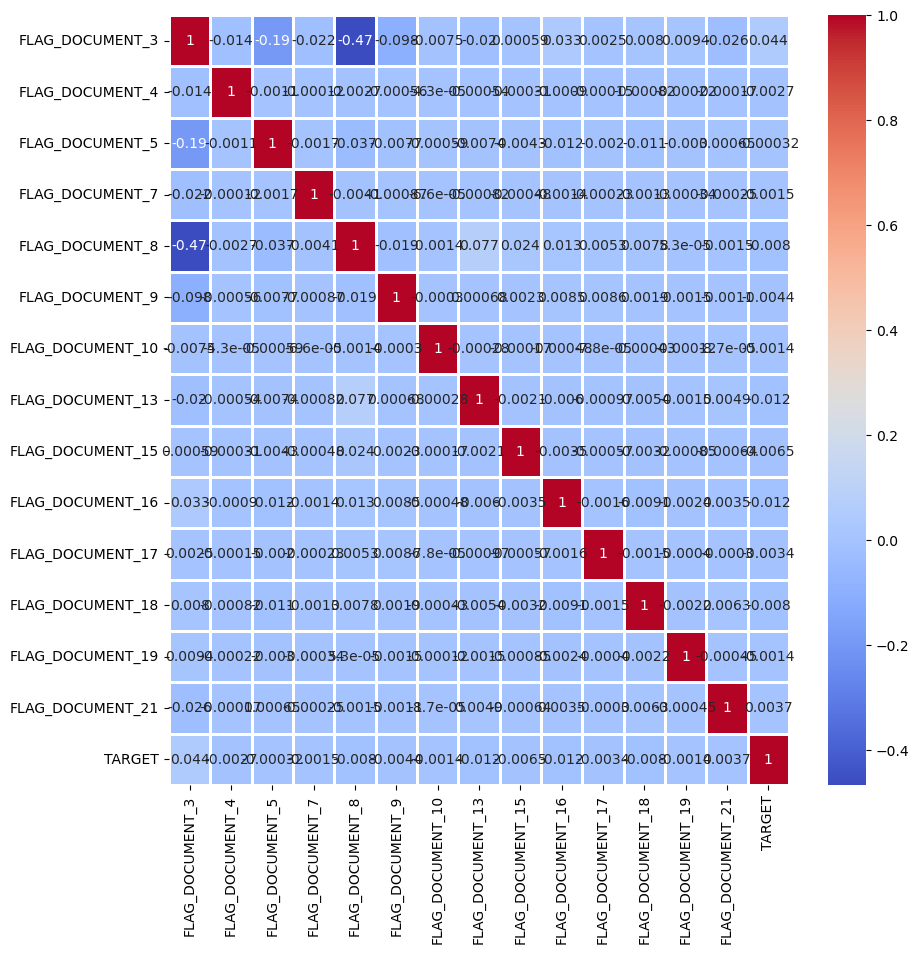

In [61]:
col_Doc = [ 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_7', 
           'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21','TARGET']
Contact_doc= data[col_Doc].corr()
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(Contact_doc,
            xticklabels=Contact_doc.columns,
            yticklabels=Contact_doc.columns,
            annot = True,
            cmap ="coolwarm",
            linewidth=1)

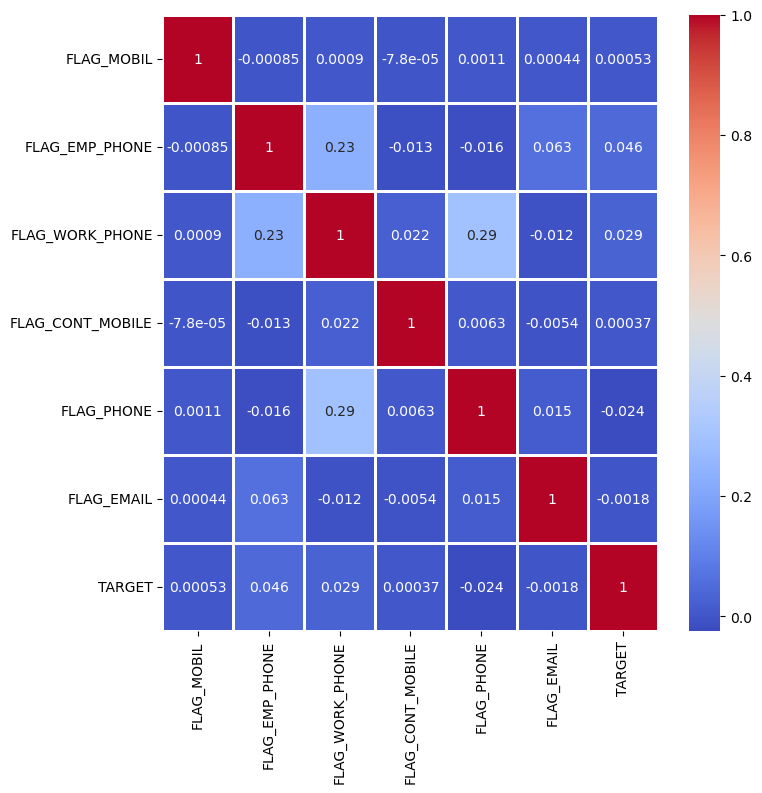

In [62]:
test2 = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL','TARGET']
Contact_corr = data[test2].corr()
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(Contact_corr,
            xticklabels=Contact_corr.columns,
            yticklabels=Contact_corr.columns,
            annot = True,
            cmap ="coolwarm",
            linewidth=1)

we see that test1 , test2 ,col_docs columns doesnt have a strong relation with target variable so we can drop all of them

In [63]:
x_train=x_train.drop(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL' ,'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_7', 
           'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_14','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'], axis=1)


In [64]:
x_test=x_test.drop(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL' ,'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_7', 
           'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_14','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'], axis=1)


In [65]:
categorical_columns2 = x_train.select_dtypes(include=['object']).columns
numerical_columns2 = x_train.select_dtypes(include=['int64', 'float64']).columns

In [66]:
x_train.shape

(246008, 93)

In [67]:
x_test.shape

(61503, 93)

In [68]:
len(numerical_columns2)

77

## Feature scaling

In [69]:
scaler = StandardScaler()
x_train_scaled=x_train
x_test_scaled=x_test
# Fit the scaler on x_train and transform x_train
x_train_scaled[numerical_columns2]=scaler.fit_transform(x_train[numerical_columns2])

# Transform x_test using the same scaler
x_test_scaled[numerical_columns2]=scaler.transform(x_test[numerical_columns2])

In [70]:
(x_train_scaled.shape)

(246008, 93)

## Target analysis

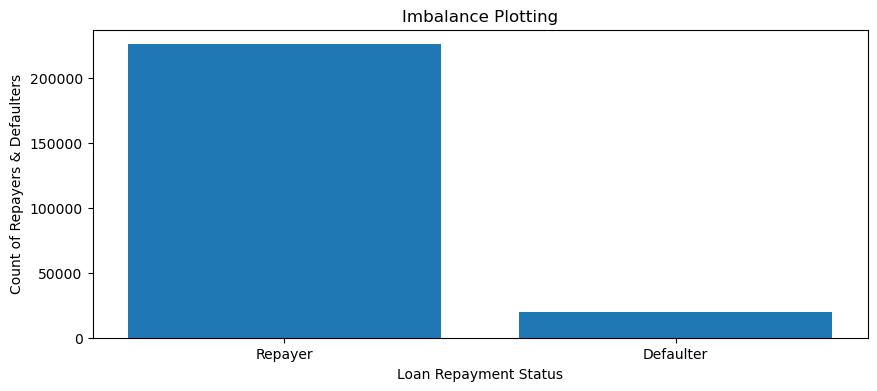

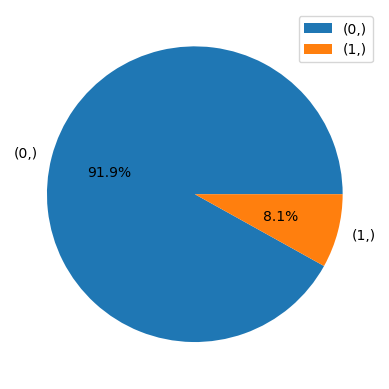

In [71]:
Imbalance = y_train.value_counts()

plt.figure(figsize=(10,4))
z= ['Repayer','Defaulter']
plt.bar(z, Imbalance)
plt.xlabel("Loan Repayment Status")
plt.ylabel("Count of Repayers & Defaulters")
plt.title("Imbalance Plotting")
plt.show()

plt.pie(Imbalance,labels=Imbalance.index,autopct='%1.1f%%')
plt.legend()

## Encoding

In [72]:
print(categorical_columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


In [73]:
col_in=x_train_scaled.columns.get_indexer(categorical_columns)
print(col_in)

[ 0  1  2  3  9 10 11 12 13 20 24 32 75 76 78 79]


In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Define the ColumnTransformer object. We have passed to it the column indices that need encoding
ct_obj =  ColumnTransformer(transformers= [("encoder", OneHotEncoder(handle_unknown='ignore'),[  1 , 2,  3,  4, 10, 11, 12, 13, 14, 21, 25, 33, 76, 77, 79, 80])] , remainder="passthrough") 
# Encode the categorical data in a similiar approach as above using the ct_obj
x_train_enc=np.array(ct_obj.fit_transform(x_train_scaled))
x_test_enc=np.array(ct_obj.transform(x_test_scaled))

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

In [ ]:
x_train_enc.shape

(246008, 216)

In [ ]:
cat=x_train_scaled.select_dtypes(include=['object'])
num=x_train_scaled.select_dtypes(exclude=['object'])
transformed_column_names =ct_obj.named_transformers_['encoder'].get_feature_names_out(cat.columns.tolist())


In [ ]:
cat_test=x_test_scaled.select_dtypes(include=['object'])
num_test=x_test_scaled.select_dtypes(exclude=['object'])
transformed_column_names_test =ct_obj.named_transformers_['encoder'].get_feature_names_out(cat_test.columns.tolist())


In [75]:
columns_names=num.columns.tolist()+transformed_column_names.tolist()
columns_names_test=num_test.columns.tolist()+transformed_column_names_test.tolist()

In [76]:
x_train_df = pd.DataFrame(x_train_enc, columns=columns_names)
x_test_df = pd.DataFrame(x_test_enc, columns=columns_names_test)

## Handling imbalance using undersampling

In [77]:
from imblearn.under_sampling import RandomUnderSampler

# Assuming you have X_train and y_train as your original training data

# Create the RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Fit and transform on the original data to obtain the undersampled data
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(x_train_df, y_train)

# Now, X_train_undersampled and y_train_undersampled contain the undersampled data


In [78]:
print(x_train_df.shape[0])
print(X_train_undersampled.shape[0])

246008
39720


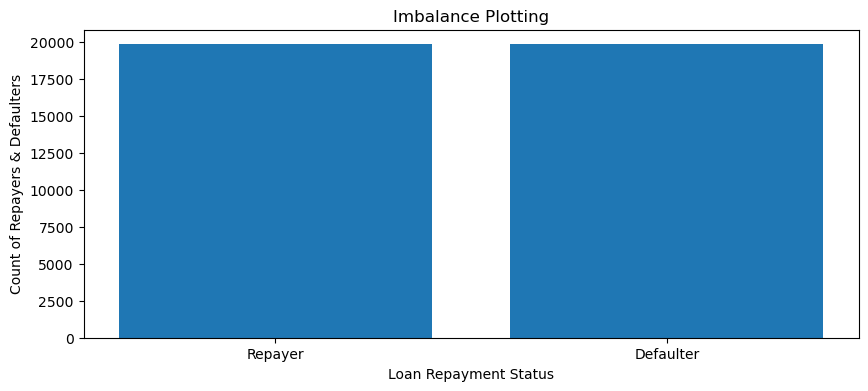

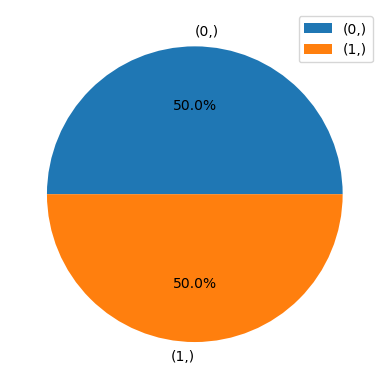

In [79]:
Imbalance = y_train_undersampled.value_counts()

plt.figure(figsize=(10,4))
z= ['Repayer','Defaulter']
plt.bar(z, Imbalance)
plt.xlabel("Loan Repayment Status")
plt.ylabel("Count of Repayers & Defaulters")
plt.title("Imbalance Plotting")
plt.show()

plt.pie(Imbalance,labels=Imbalance.index,autopct='%1.1f%%')
plt.legend()

## Feature imporatnce

In [80]:

# Create a Random Forest classifier
# clf = RandomForestClassifier(random_state=42)
# # Fit the classifier to the training data
# clf.fit(X_train_undersampled, y_train_undersampled)
# # Use feature importances for feature selection
# sfm = SelectFromModel(clf, threshold=-np.inf, max_features=80)
# x_train_selected = sfm.fit_transform(X_train_undersampled, y_train_undersampled)
# x_test_selected = sfm.transform(x_test_df)



rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)
# fit the model to the training set
rfc_100.fit(X_train_undersampled, y_train_undersampled)
# Predict on the test set results
y_pred_100 = rfc_100.predict(x_test_df)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
# fit the model to the training se
clf.fit(X_train_undersampled, y_train_undersampled)
feature_scores = pd.Series(clf.feature_importances_, index=X_train_undersampled.columns).sort_values(ascending=False)

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))


# pca=PCA(n_components=60)
# x_train_selected = pca.fit_transform(X_train_undersampled)
# x_test_selected = pca.transform(x_test_df)




c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model accuracy score with 100 decision-trees : 0.6498


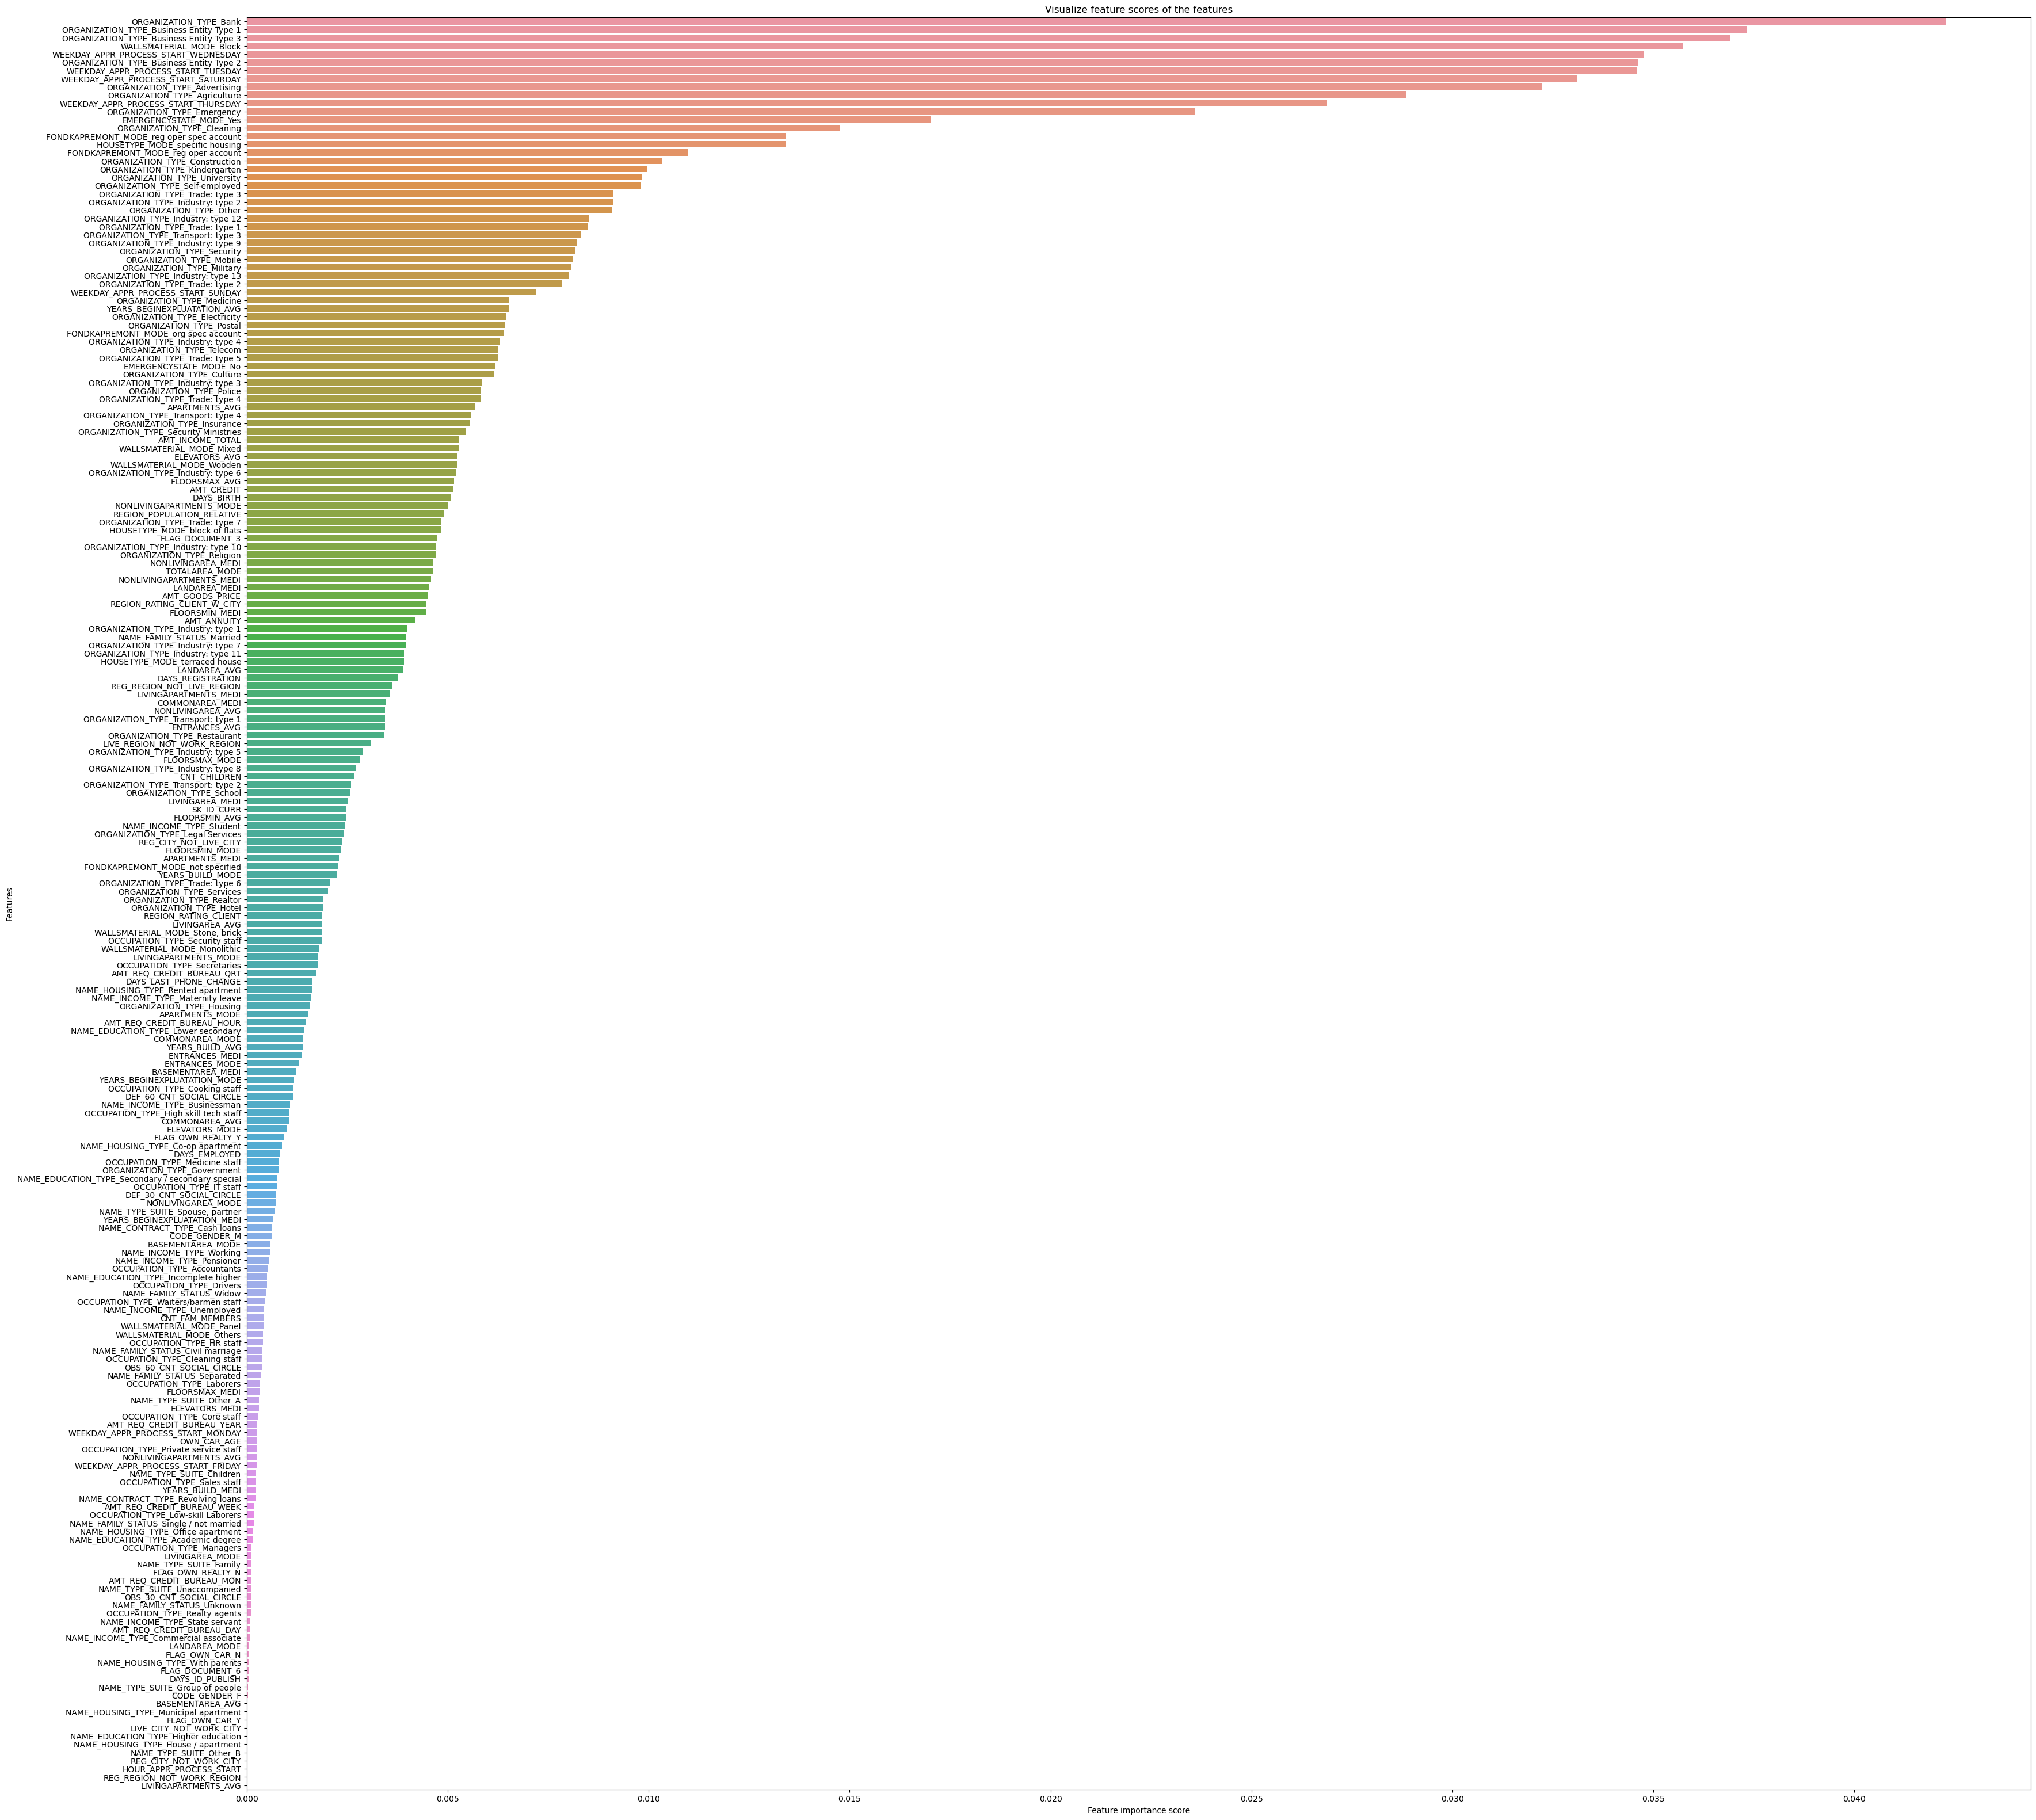

In [81]:
f, ax = plt.subplots(figsize=(40, 40))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [82]:
x_train_selected = X_train_undersampled
x_test_selected=x_test_df
x_train_selected=x_train_selected.drop(['LIVINGAPARTMENTS_AVG','REG_REGION_NOT_WORK_REGION','HOUR_APPR_PROCESS_START','REG_CITY_NOT_WORK_CITY','NAME_TYPE_SUITE_Other_B','NAME_HOUSING_TYPE_House / apartment','NAME_EDUCATION_TYPE_Higher education',
                                        'BASEMENTAREA_AVG' ,'NAME_HOUSING_TYPE_Municipal apartment','FLAG_OWN_CAR_Y','LIVE_CITY_NOT_WORK_CITY'],axis=1)
x_test_selected=x_test_selected.drop(['LIVINGAPARTMENTS_AVG','REG_REGION_NOT_WORK_REGION','HOUR_APPR_PROCESS_START','REG_CITY_NOT_WORK_CITY','NAME_TYPE_SUITE_Other_B','NAME_HOUSING_TYPE_House / apartment','NAME_EDUCATION_TYPE_Higher education',
                                        'BASEMENTAREA_AVG' ,'NAME_HOUSING_TYPE_Municipal apartment','FLAG_OWN_CAR_Y','LIVE_CITY_NOT_WORK_CITY'],axis=1)

In [83]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)



# fit the model to the training set

clf.fit(x_train_selected, y_train_undersampled)


# Predict on the test set results

y_pred = clf.predict(x_test_selected)



# Check accuracy score 

print('Model accuracy score  : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model accuracy score  : 0.6517


## Modeling

## NOTE:
Feature importance doesnot really affect the model evaluation \
my suggestion that : \
i dropped already non important features so feature importance doesn't do anything


In [84]:
model = LogisticRegression(random_state=42)

# Train the model on the training data
model.fit(x_train_selected, y_train_undersampled)

# Make predictions on the test data
y_pred = model.predict(x_test_selected)

# Generate a classification report
report = classification_report(y_test, y_pred)


# Print the classification report
print("Classification Report:\n", report)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.63      0.76     56538
           1       0.13      0.63      0.21      4965

    accuracy                           0.63     61503
   macro avg       0.54      0.63      0.49     61503
weighted avg       0.88      0.63      0.71     61503



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Tunning the model

In [85]:
# Define the parameter search space
param_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],           # Regularization penalty ('l1' or 'l2')
    'solver': ['liblinear', 'saga'],   # Algorithm to use for optimization
}

# Perform Bayesian optimization for hyperparameter tuning
opt = BayesSearchCV(
    model,
    param_space,
    cv=5,        # Number of cross-validation folds
    scoring='precision'
)

# Fit the model with the optimized hyperparameters
opt.fit(x_train_selected, y_train_undersampled)

# Print the best hyperparameters found
print("Best hyperparameters:", opt.best_params_)

# Evaluate the model on the test set
test_score = opt.score(x_test_selected, y_test)
print("Test set accuracy:", test_score)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

In [46]:
# Define the hyperparameter search space
param_dist = {
    'penalty': ['l2'],  # Regularization penalty
    'C':[0.001,0.01,0.1,1,10,100],                   # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Solver algorithm
    'max_iter': [1000,3000,4000],         # Maximum number of iterations
}

# Create a logistic regression classifier
lr = LogisticRegression()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV( lr, param_distributions=param_dist, scoring='precision', cv=3, )

# Fit the random search to the training data
random_search.fit(x_train_selected, y_train_undersampled)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 1000, 'C': 100}
Best Score: 0.6282326662229142
